# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)


In [2]:
# reading the  data
churn_train = pd.read_csv("train.csv")
churn_test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
Data_dictionary = pd.read_csv("data_dictionary.csv")

## Data Understanding

In [3]:
churn_train.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [4]:
churn_test.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   65.330   64.445        31.78        20.23        23.11         60.16   
1  515.568  360.868        75.51        41.21        19.84        474.34   
2  434.884  746.239         7.54         7.86         8.40         16.98   
3  171.390   24.400         5.31         2.16         0.00         40.04   
4  406.289  413.329       450.93       609.03       700.68         60.94   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         32.16         34.83           0.00           0.00           0.00   
1        621.84        394.94           0.00           0.00           0.00   
2         45.81         45.04          22.81         103.38          26.08   
3        205.01         24.01           0.00           0.00           0.00   
4         23.84         74.16           0.00           0.00           0.00   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00           0.00           0.00             24.88   
1           0.00           0.00           0.00             75.51   
2          24.53          53.68          54.44              0.00   
3           0.00           0.00           0.00              5.31   
4           0.00           0.00           0.00              0.45   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             20.23             21.06             18.13             10.89   
1             41.21             19.84            473.61            598.08   
2              0.00              0.00              0.00              0.00   
3              0.00              0.00              2.94             98.61   
4              0.78             14.56              2.39              2.66   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              8.36              0.00             13.58              0.00   
1            377.26              0.73              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             20.51              0.00              0.00              2.35   
4             10.94              0.00              0.00              0.00   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0              0.00              0.03         43.01   
1               0.0              0.00              0.00        549.86   
2               0.0              0.00              0.00          0.00   
3               0.0              6.18              0.00          8.26   
4               0.0              0.00              0.00          2.84   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         44.71         29.43              6.90              0.00   
1        639.29        397.11              0.00              0.00   
2          0.00          0.00              0.00              0.00   
3         98.61         22.86              0.00              2.16   
4          3.44         25.51            450.48            608.24   

 

In [5]:
churn_train.shape,churn_test.shape

((69999, 172), (30000, 171))

In [6]:
sample.shape

(30000, 2)

In [7]:
Data_dictionary

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [8]:
churn_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [9]:
churn_train.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   67231.000000   67312.000000   66296.000000   67231.000000   
mean        9.765435       7.014568       7.004892      14.186457   
std        57.374429      55.960985      53.408135      73.469261   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   67312.000000   66296.000000      67231.000000      67312.000000   
mean        9.842191       9.771783         46.904854         46.166503   
std        58.511894      64.618388        150.971758        154.739002   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000   
50%         0.000000       0.000000         11.910000         11.580000   
75%         0.000000       0.000000         40.740000         39.760000   
max      2812.040000    5337.040000       6431.330000       7400.660000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count      66296.000000      67231.000000      67312.000000      66296.000000   
mean          45.686109         93.238231         90.799240         91.121447   
std          153.716880        162.046699        153.852597        152.997805   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.610000          9.920000         10.090000          9.830000   
50%           11.740000         41.030000         40.170000         40.350000   
75%           39.895000        110.430000        107.540000        109.245000   
max        10752.560000       4696

In [10]:
#Creating copy of Training and testing dataset
telecom_train=churn_train.copy()
telecom_test=churn_test.copy()

## Data Cleaning and Preparation

### Checking fo null values in training and test data

In [11]:
round(100*(telecom_train.isnull().sum())/len(telecom_train), 2).sort_values()

id                           0.00
last_day_rch_amt_8           0.00
last_day_rch_amt_7           0.00
last_day_rch_amt_6           0.00
max_rech_amt_8               0.00
max_rech_amt_7               0.00
max_rech_amt_6               0.00
total_rech_amt_8             0.00
total_rech_amt_7             0.00
total_rech_amt_6             0.00
total_rech_num_8             0.00
total_rech_num_7             0.00
total_rech_num_6             0.00
total_ic_mou_8               0.00
total_ic_mou_7               0.00
total_ic_mou_6               0.00
jun_vbc_3g                   0.00
total_og_mou_8               0.00
vol_2g_mb_6                  0.00
total_og_mou_7               0.00
vol_2g_mb_7                  0.00
vol_3g_mb_6                  0.00
jul_vbc_3g                   0.00
aug_vbc_3g                   0.00
aon                          0.00
sachet_3g_8                  0.00
sachet_3g_7                  0.00
sachet_3g_6                  0.00
monthly_3g_8                 0.00
monthly_3g_7  

#### checking for duplicate values

In [12]:
telecom_train.nunique().sort_values()

std_ic_t2o_mou_6                1
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
std_ic_t2o_mou_8                1
std_og_t2c_mou_8                1
std_og_t2c_mou_7                1
std_og_t2c_mou_6                1
std_ic_t2o_mou_7                1
night_pck_user_6                2
night_pck_user_7                2
night_pck_user_8                2
churn_probability               2
fb_user_7                       2
fb_user_8                       2
fb_user_6                       2
monthly_2g_6                    5
monthly_2g_8                    6
monthly_2g_7                    6
monthly_3g_6                   10
monthly_3g_8                   12
monthly_3g_7                   13
sachet_3g_6                    23
count_rech_3g_6                23
sachet_3g_7                    26
count_rech_3g_

In [13]:
telecom_test.nunique().sort_values()

std_ic_t2o_mou_8                1
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
std_ic_t2o_mou_6                1
std_og_t2c_mou_8                1
std_og_t2c_mou_7                1
std_og_t2c_mou_6                1
std_ic_t2o_mou_7                1
night_pck_user_7                2
night_pck_user_6                2
night_pck_user_8                2
fb_user_6                       2
fb_user_7                       2
fb_user_8                       2
monthly_2g_6                    5
monthly_2g_8                    6
monthly_2g_7                    6
monthly_3g_8                   10
monthly_3g_6                   11
monthly_3g_7                   12
count_rech_3g_8                19
sachet_3g_8                    20
sachet_3g_6                    22
sachet_3g_7                    22
count_rech_3g_

In [14]:
#Train data having single value columns(13)
cols_with_single_value = []
for col in telecom_train.columns:
    if telecom_train[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)


['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [15]:
#Test data having single value columns(13)
cols_with_single_value = []
for col in telecom_test.columns:
    if telecom_test[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [16]:
# Based on the dataset, we will remove these columns from the training set
telecom_train.drop(cols_with_single_value, axis=1, inplace=True)

# Based on the dataset, we will remove these columns from the test set
telecom_test.drop(cols_with_single_value, axis=1, inplace=True)

In [17]:
#Dropping the id column  as it has all unique values
telecom_train.drop('id', axis=1, inplace=True)

In [18]:
telecom_train.shape,telecom_test.shape

((69999, 158), (30000, 158))

In [19]:
telecom_train.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [20]:

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

numerical_cols = [col for col in telecom_train.columns if col not in date_cols + cat_cols]

In [21]:
# Dropping date columns as they are not useful for our analysis from the training set
telecom_train.drop(columns=date_cols, axis=1, inplace=True)

# Dropping date columns as they are not useful for our analysis from the test set
telecom_test.drop(columns=date_cols, axis=1, inplace=True)

In [22]:
telecom_train.shape

(69999, 152)

In [23]:
### Check for columns with more than 70% missing values in the training dataset
missing_data = round(100*(telecom_train.isna().sum(axis=0)/telecom_train.shape[0]), 2)
missing_data[missing_data > 70].sort_values(ascending=False)

total_rech_data_6     74.90
arpu_3g_6             74.90
max_rech_data_6       74.90
fb_user_6             74.90
count_rech_2g_6       74.90
night_pck_user_6      74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
av_rech_amt_data_6    74.90
fb_user_7             74.48
night_pck_user_7      74.48
arpu_2g_7             74.48
arpu_3g_7             74.48
av_rech_amt_data_7    74.48
total_rech_data_7     74.48
count_rech_3g_7       74.48
count_rech_2g_7       74.48
max_rech_data_7       74.48
av_rech_amt_data_8    73.69
count_rech_3g_8       73.69
arpu_3g_8             73.69
count_rech_2g_8       73.69
arpu_2g_8             73.69
max_rech_data_8       73.69
night_pck_user_8      73.69
total_rech_data_8     73.69
fb_user_8             73.69
dtype: float64

In [24]:
# Columns with recharge information 
recharge_cols = telecom_train.columns[telecom_train.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [25]:
# Replacing NaN values in recharge related columns with 0 in the training set
telecom_train[recharge_cols] = telecom_train[recharge_cols].fillna(0)
print(telecom_train[recharge_cols].isnull().sum()*100/telecom_train.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [26]:
# Replacing NaN values in recharge related columns with 0 in the test set
telecom_test[recharge_cols] = telecom_test[recharge_cols].fillna(0)
print(telecom_test[recharge_cols].isnull().sum()*100/telecom_test.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [27]:
# Columns with 'arpu' information 
arpu_cols = telecom_train.columns[telecom_train.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [28]:
# Replacing NaN values in ARPU related columns with 0 in the training set
telecom_train[arpu_cols] = telecom_train[arpu_cols].fillna(0)
print(telecom_train[arpu_cols].isnull().sum()*100/telecom_train.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [29]:
# Replacing NaN values in ARPU related columns with 0 in the test set
telecom_test[arpu_cols] = telecom_test[arpu_cols].fillna(0)
print(telecom_test[arpu_cols].isnull().sum()*100/telecom_test.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


Categorical Columns


In [30]:
# Inspecting categorical columns
telecom_train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


In [31]:
from numpy import isnan
from sklearn.impute import SimpleImputer

Imputing categorical variables using simple imputer

In [32]:
imp = SimpleImputer(strategy='most_frequent', fill_value=0)
telecom_train[cat_cols] = imp.fit_transform(telecom_train[cat_cols])

In [33]:
telecom_train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  69999 non-null  float64
 1   night_pck_user_7  69999 non-null  float64
 2   night_pck_user_8  69999 non-null  float64
 3   fb_user_6         69999 non-null  float64
 4   fb_user_7         69999 non-null  float64
 5   fb_user_8         69999 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


In [34]:
telecom_train[cat_cols]=telecom_train[cat_cols].astype('category')

In [35]:
telecom_train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.0 KB


In [36]:
round(100*(telecom_train.isnull().sum())/len(telecom_train), 2).sort_values

<bound method Series.sort_values of arpu_6                0.00
arpu_7                0.00
arpu_8                0.00
onnet_mou_6           3.95
onnet_mou_7           3.84
onnet_mou_8           5.29
offnet_mou_6          3.95
offnet_mou_7          3.84
offnet_mou_8          5.29
roam_ic_mou_6         3.95
roam_ic_mou_7         3.84
roam_ic_mou_8         5.29
roam_og_mou_6         3.95
roam_og_mou_7         3.84
roam_og_mou_8         5.29
loc_og_t2t_mou_6      3.95
loc_og_t2t_mou_7      3.84
loc_og_t2t_mou_8      5.29
loc_og_t2m_mou_6      3.95
loc_og_t2m_mou_7      3.84
loc_og_t2m_mou_8      5.29
loc_og_t2f_mou_6      3.95
loc_og_t2f_mou_7      3.84
loc_og_t2f_mou_8      5.29
loc_og_t2c_mou_6      3.95
loc_og_t2c_mou_7      3.84
loc_og_t2c_mou_8      5.29
loc_og_mou_6          3.95
loc_og_mou_7          3.84
loc_og_mou_8          5.29
std_og_t2t_mou_6      3.95
std_og_t2t_mou_7      3.84
std_og_t2t_mou_8      5.29
std_og_t2m_mou_6      3.95
std_og_t2m_mou_7      3.84
std_og_t2m_mou_8   

In [37]:
imp = SimpleImputer(strategy='most_frequent', fill_value=0)
telecom_test[cat_cols] = imp.fit_transform(telecom_test[cat_cols])

In [38]:
telecom_test[cat_cols]=telecom_test[cat_cols].astype('category')

In [39]:
telecom_test[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  30000 non-null  category
 1   night_pck_user_7  30000 non-null  category
 2   night_pck_user_8  30000 non-null  category
 3   fb_user_6         30000 non-null  category
 4   fb_user_7         30000 non-null  category
 5   fb_user_8         30000 non-null  category
dtypes: category(6)
memory usage: 176.6 KB


In [40]:
# Checking for the columns which have missing values present
missing_final_list=missing_data[(missing_data > 0) & (missing_data <= 70)].sort_values(ascending=False)
missing_final_list

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
og_others_8         5.29
std_og_t2m_mou_8    5.29
loc_ic_t2t_mou_8    5.29
std_og_t2t_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_og_mou_8        5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2c_mou_8    5.29
loc_ic_mou_8        5.29
isd_og_mou_8        5.29
std_ic_t2t_mou_8    5.29
loc_og_t2f_mou_8    5.29
std_ic_t2m_mou_8    5.29
spl_ic_mou_8        5.29
onnet_mou_8         5.29
loc_og_t2t_mou_8    5.29
std_ic_t2f_mou_8    5.29
isd_ic_mou_8        5.29
roam_og_mou_8       5.29
std_ic_mou_8        5.29
offnet_mou_8        5.29
roam_ic_mou_8       5.29
ic_others_6         3.95
og_others_6         3.95
loc_ic_t2t_mou_6    3.95
isd_ic_mou_6        3.95
spl_ic_mou_6        3.95
loc_ic_t2m_mou_6    3.95
std_ic_t2m_mou_6    3.95
loc_ic_t2f_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_mou_6        3.95
std_ic_t2t_mou_6    3.95
std_ic_t2f_mou_6    3.95
spl_og_mou_6        3.95


Deriving New Features

<br>We can create a new feature named Total Data Recharge Amount by multiplying the values of total_rech_data and av_rech_amt_data, which represents the amount recharged by the customer for data usage.

<br>Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount
<br>Created another column for total recharge done Total Amount for the months 6 and 7.

<br>Total Amount = Total Data Recharge Amount + Total Recharge Amount
<br>Additionally, we can compute the Total Average Recharge Amount during the 'Good Phase', which includes months 6 and 7.

<br>Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2

In [41]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
telecom_train['total_rech_data_amt_6'] = telecom_train['total_rech_data_6'] * telecom_train['av_rech_amt_data_6']
telecom_train['total_rech_data_amt_7'] = telecom_train['total_rech_data_7'] * telecom_train['av_rech_amt_data_7']

telecom_train['total_amt_6'] = telecom_train['total_rech_data_amt_6'] + telecom_train['total_rech_amt_6']
telecom_train['total_amt_7'] = telecom_train['total_rech_data_amt_7'] + telecom_train['total_rech_amt_7']

telecom_train['total_avg_amt_6_7'] = telecom_train[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [42]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

telecom_train.drop(drop_data_cols, axis=1, inplace=True)

In [43]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
telecom_test['total_rech_data_amt_6'] = telecom_test['total_rech_data_6'] * telecom_test['av_rech_amt_data_6']
telecom_test['total_rech_data_amt_7'] = telecom_test['total_rech_data_7'] * telecom_test['av_rech_amt_data_7']

telecom_test['total_amt_6'] = telecom_test['total_rech_data_amt_6'] + telecom_test['total_rech_amt_6']
telecom_test['total_amt_7'] = telecom_test['total_rech_data_amt_7'] + telecom_test['total_rech_amt_7']

telecom_test['total_avg_amt_6_7'] = telecom_test[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
telecom_test.drop(drop_data_cols, axis=1, inplace=True)

In [44]:
# Checking for any null value in the derived column in the training set
telecom_train['total_avg_amt_6_7'].isnull().sum()

0

In [45]:
telecom_train.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [46]:
telecom_train.shape,telecom_test.shape

((69999, 149), (30000, 149))

In [47]:
# Checking for any null value in the derived column in the test set
telecom_test['total_avg_amt_6_7'].isnull().sum()

0

In [48]:
# Finding cutoff value for only top 70% of high value customers
cutoff = telecom_train['total_avg_amt_6_7'].quantile(0.7)
cutoff

477.5

In [49]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
#high_telecom_train = telecom_train[(telecom_train['total_avg_amt_6_7'] > cutoff)].copy()
high_telecom_train = telecom_train.copy()

print(high_telecom_train.shape)

(69999, 149)


## Analysing our target variable churn_probability

In [50]:
high_telecom_train['churn_probability'].dtype

dtype('int64')

This variable needs to change to category dtype as it is a classification variable.



In [51]:
high_telecom_train['churn_probability'] = high_telecom_train['churn_probability'].astype('category')

In [52]:
# Verify the new dtype
high_telecom_train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [53]:
# Check the value counts of churn and not-churn
print(high_telecom_train['churn_probability'].value_counts())

print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(high_telecom_train['churn_probability'].value_counts()*100/high_telecom_train.shape[0])

churn_probability
0    62867
1     7132
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    89.811283
1    10.188717
Name: count, dtype: float64


<Figure size 700x700 with 0 Axes>

<Axes: xlabel='churn_probability', ylabel='count'>

Text(0.5, 0, 'Customer churn')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Customer churn distribution')

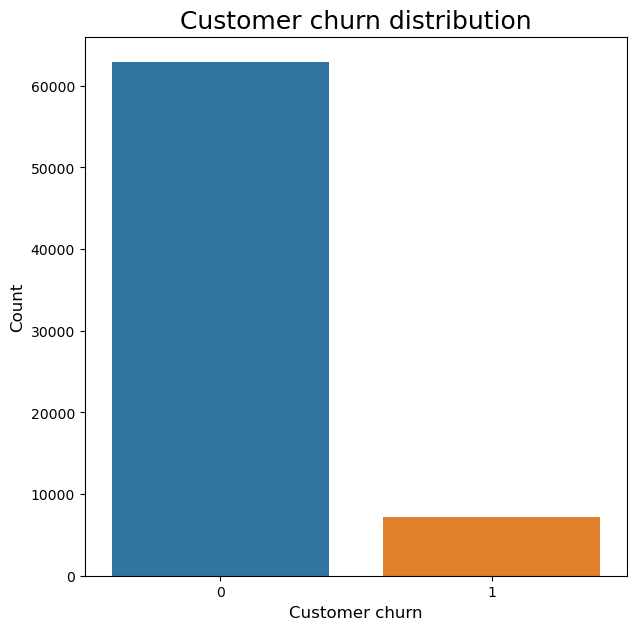

In [54]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_telecom_train['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

Based on the visualization, it's evident that 91.73% of customers are non-churn, while 8.26% of customers churn. This indicates a noticeable class imbalance, which we will address later.


In [55]:
# Create a copy of high_telecom_train df and use the new df (churn_data) for pruning in the training set
churn_telecom_data = high_telecom_train.copy()
churn_telecom_data.reset_index(inplace=True)
churn_telecom_data.drop(['index'], axis=1, inplace=True)

In [56]:
churn_telecom_data.shape

(69999, 149)

In [57]:
# Get the list of columns with missing values in the training set
mv = round(100*(churn_telecom_data.isnull().sum(axis=0)/churn_telecom_data.shape[0]), 2)
s = mv.loc[mv>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [58]:
#Values missing from dataset
drop = high_telecom_train.dropna()
print(churn_telecom_data.shape[0] - drop.shape[0])

6157


### Impute missing values using KNN Imputer - Training Set

In [59]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [60]:
# Separate df having columns to be imputed
df_num = churn_telecom_data[impute_cols_num]
df_churn = churn_telecom_data.drop(impute_cols_num, axis=1)

In [61]:
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

In [62]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        48.58       124.38         1.29         32.24         96.68   
1         0.00         0.00         0.00          0.00         25.99   
2         0.53        15.93         0.00         53.99         82.05   
3         7.26        16.01         0.00         68.76         78.48   
4        21.28         4.83         6.13         56.99         38.11   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          2.33           0.00            0.0            0.0           0.00   
1         30.89           0.00            0.0            0.0           0.00   
2          0.00           0.00            0.0            0.0           0.00   
3         50.23           0.00            0.0            0.0           0.00   
4          9.63          53.64            0.0            0.0          15.73   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0           0.00              2.23              0.00   
1            0.0           0.00              0.00              0.00   
2            0.0           0.00              0.53             12.98   
3            0.0           1.63              6.99              3.94   
4            0.0           0.00             10.16              4.83   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              0.28              5.29             16.04              2.33   
1              0.00              0.00              0.00              0.00   
2              0.00             24.11              0.00              0.00   
3              0.00             37.91             44.89             23.63   
4              6.13             36.74             19.88              4.61   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              2.14   
3              0.00              0.00              0.00              0.00   
4             11.99              1.23              5.01              0.00   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.00          7.53         16.04   
1             22.01             29.79          0.00          0.00   
2              0.00              0.00         24.64         12.98   
3              0.00              8.03         44.91         48.84   
4              9.85              0.00         58.91         25.94   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0          2.61             46.34            124.38              1.01   
1          0.00              0.00              0.00              0.00   
2          0.00              0.00              2.94              0.00   
3         23.63              0.26             12.06              0.00   
4         15.76              0.00              0.00              0.00   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             18.75             80.61               0.0              0.00   
1              0.00              0.00               0.0              0.00   
2             28.94             82.05               0.0              0.00   
3             15.33             25.93               4.6              0.56   
4              4.35              0.00               0.0              0.00   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         65.09        204.99   
1               0.0               0.0          0.00          0.00   
2               0.0               0.0         28.94         84.99   
3               0.0               0.0         16.16         37.99   
4               0.0               0.0          4.35          0.00   

   std_og_

In [63]:
# Merge the two dataframes together post imputation to create the final training set
final_telecom = pd.concat([df_imp, df_churn ], join='inner', axis=1)
final_telecom .head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        48.58       124.38         1.29         32.24         96.68   
1         0.00         0.00         0.00          0.00         25.99   
2         0.53        15.93         0.00         53.99         82.05   
3         7.26        16.01         0.00         68.76         78.48   
4        21.28         4.83         6.13         56.99         38.11   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          2.33           0.00            0.0            0.0           0.00   
1         30.89           0.00            0.0            0.0           0.00   
2          0.00           0.00            0.0            0.0           0.00   
3         50.23           0.00            0.0            0.0           0.00   
4          9.63          53.64            0.0            0.0          15.73   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0           0.00              2.23              0.00   
1            0.0           0.00              0.00              0.00   
2            0.0           0.00              0.53             12.98   
3            0.0           1.63              6.99              3.94   
4            0.0           0.00             10.16              4.83   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              0.28              5.29             16.04              2.33   
1              0.00              0.00              0.00              0.00   
2              0.00             24.11              0.00              0.00   
3              0.00             37.91             44.89             23.63   
4              6.13             36.74             19.88              4.61   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              2.14   
3              0.00              0.00              0.00              0.00   
4             11.99              1.23              5.01              0.00   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.00          7.53         16.04   
1             22.01             29.79          0.00          0.00   
2              0.00              0.00         24.64         12.98   
3              0.00              8.03         44.91         48.84   
4              9.85              0.00         58.91         25.94   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0          2.61             46.34            124.38              1.01   
1          0.00              0.00              0.00              0.00   
2          0.00              0.00              2.94              0.00   
3         23.63              0.26             12.06              0.00   
4         15.76              0.00              0.00              0.00   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             18.75             80.61               0.0              0.00   
1              0.00              0.00               0.0              0.00   
2             28.94             82.05               0.0              0.00   
3             15.33             25.93               4.6              0.56   
4              4.35              0.00               0.0              0.00   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         65.09        204.99   
1               0.0               0.0          0.00          0.00   
2               0.0               0.0         28.94         84.99   
3               0.0               0.0         16.16         37.99   
4               0.0               0.0          4.35          0.00   

   std_og_

In [64]:
final_telecom.shape

(69999, 149)

In [65]:
# Verify no missing value is present in the training set now
final_telecom.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_7      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
count_rech_3g_8       0
total_rech_amt_8      0
total_rech_amt_6      0
isd_ic_mou_6          0
total_rech_num_8      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
vol_3g_mb_6           0
monthly_3g_7          0
monthly_3g_8    

 Impute missing values using the KNN Imputer - Test Set

In [66]:
# Separate df having columns to be imputed
df_num_test = telecom_test[impute_cols_num]
df_churn_test = telecom_test.drop(impute_cols_num, axis=1)

In [67]:
# Impute using KNN imputer instance
df_imp_test = imputer.transform(df_num_test)

In [68]:
# Convert it to df post imputation
df_imp_test = pd.DataFrame(df_imp_test, columns=impute_cols_num)
df_imp_test.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [69]:
# Merge the two dataframes together post imputation
final_telecom_test = pd.concat([df_imp_test, df_churn_test ], join='inner', axis=1)
final_telecom_test.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [70]:
final_telecom_test.shape

(30000, 149)

In [71]:
# Verify no missing value is present in the test set now
final_telecom_test.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_6      0
total_rech_amt_8      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
total_rech_amt_7      0
total_rech_num_8      0
isd_ic_mou_6          0
total_rech_num_7      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
id                    0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
count_rech_3g_8       0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
monthly_3g_6          0
monthly_3g_7    

### Exploratory Data Analysis (EDA)

In [72]:
def plot_bar_graph(title, month, y_list, data):
   
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

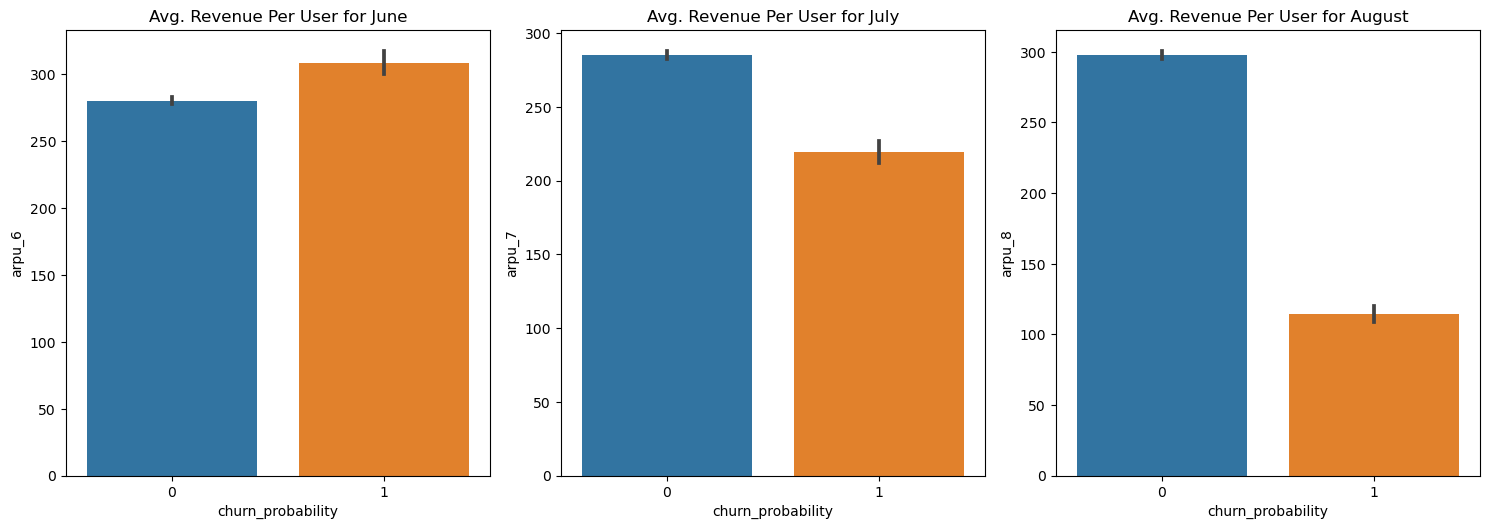

In [73]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_telecom)

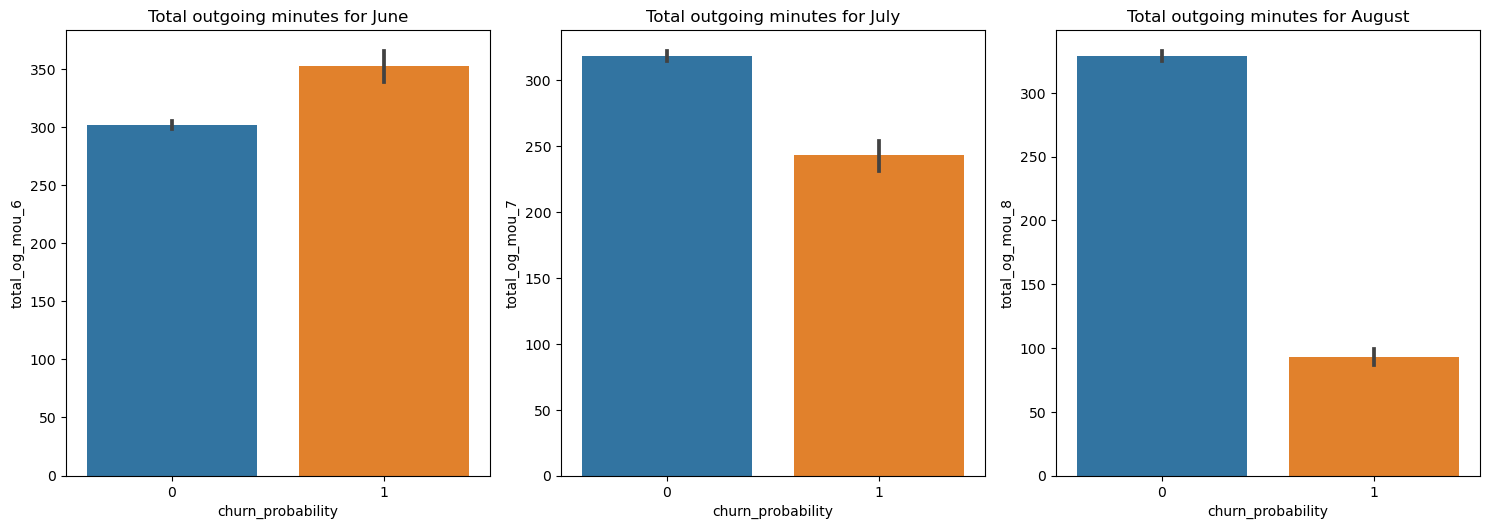

In [74]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_telecom)

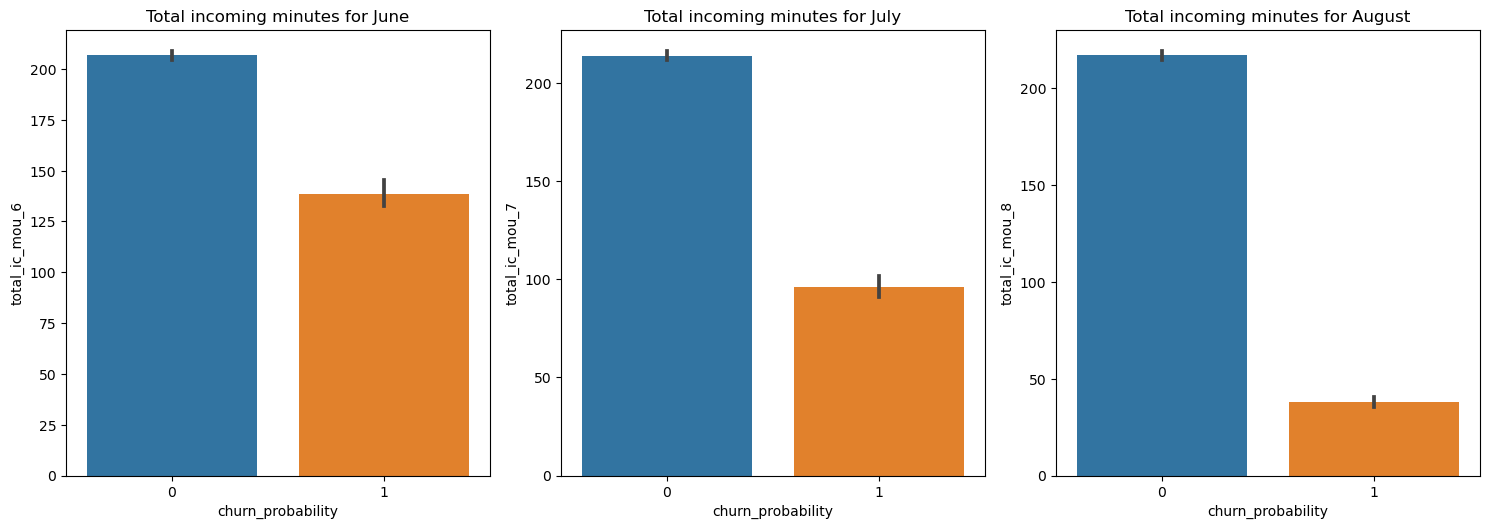

In [75]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_telecom)

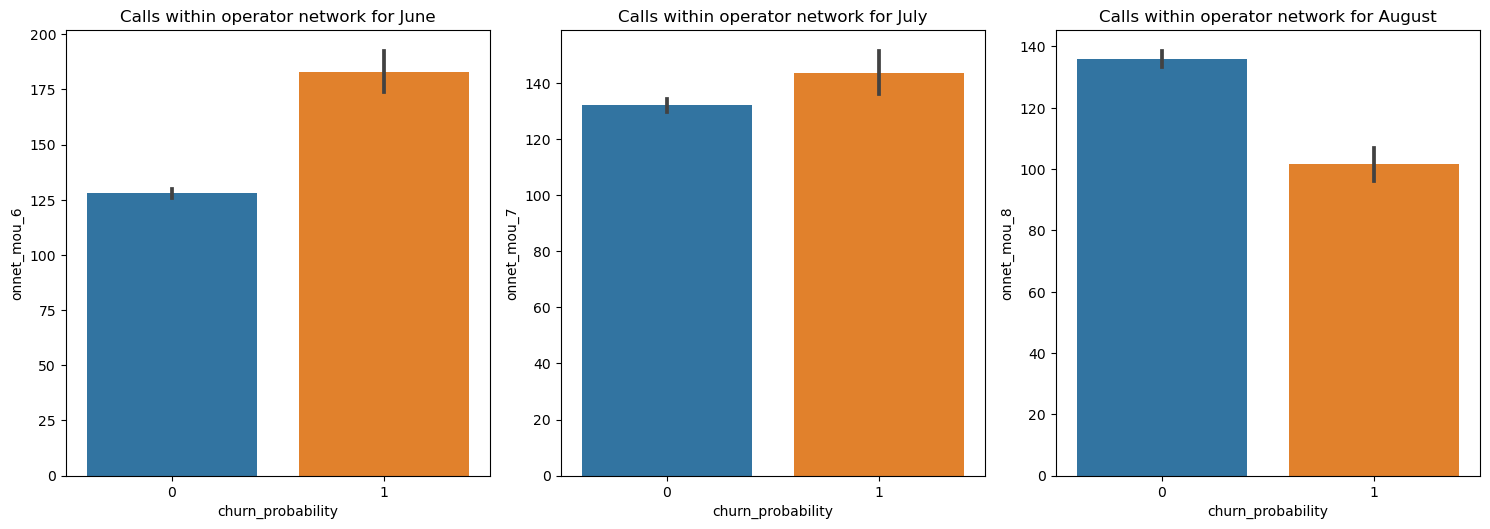

In [76]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, final_telecom)

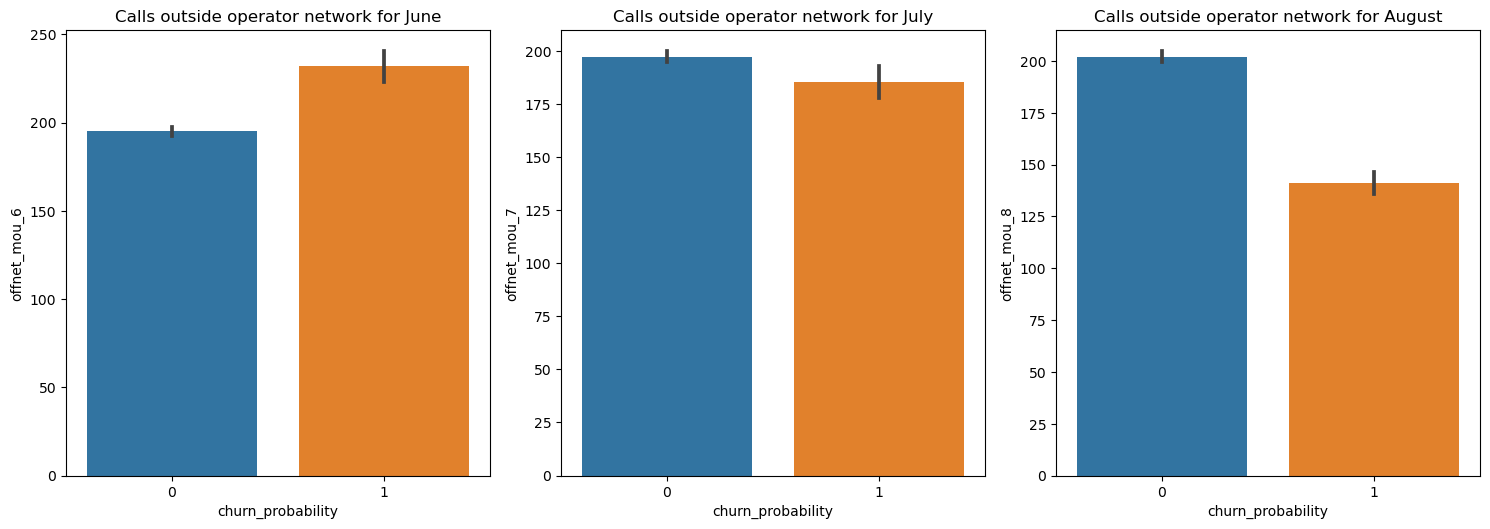

In [77]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_telecom)

### Dummy Variable Creation (One Hot Encoding) - Training Set

In [78]:
# Creating dummies for categorical columns
dummy_telecom_train = pd.get_dummies(final_telecom[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [79]:
final_telecom = pd.concat([final_telecom, dummy_telecom_train], axis=1)

In [80]:
# drop the category cols
final_telecom.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)
final_telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 149 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int32(6), int64(25)
memory usage: 77.5 MB


In [81]:
final_telecom.info(),final_telecom.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 149 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int32(6), int64(25)
memory usage: 77.5 MB


(None, (69999, 149))

In [82]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_telecom.loc[:, final_telecom.columns.str.contains('amt')]
data2g = final_telecom.loc[:, final_telecom.columns.str.contains('2g')]
data3g = final_telecom.loc[:, final_telecom.columns.str.contains('3g')]
ic_mou_data = final_telecom.loc[:, final_telecom.columns.str.contains('ic') & final_telecom.columns.str.contains('mou')]
net_mou_data = final_telecom.loc[:, final_telecom.columns.str.contains('net_mou')]
og_mou_data = final_telecom.loc[:, final_telecom.columns.str.contains('og') & final_telecom.columns.str.contains('mou')]
rech_data = final_telecom.loc[:, final_telecom.columns.str.contains('rech')]
total_data = final_telecom.loc[:, final_telecom.columns.str.contains('tot')]

<Figure size 1000x1000 with 0 Axes>

<Axes: >

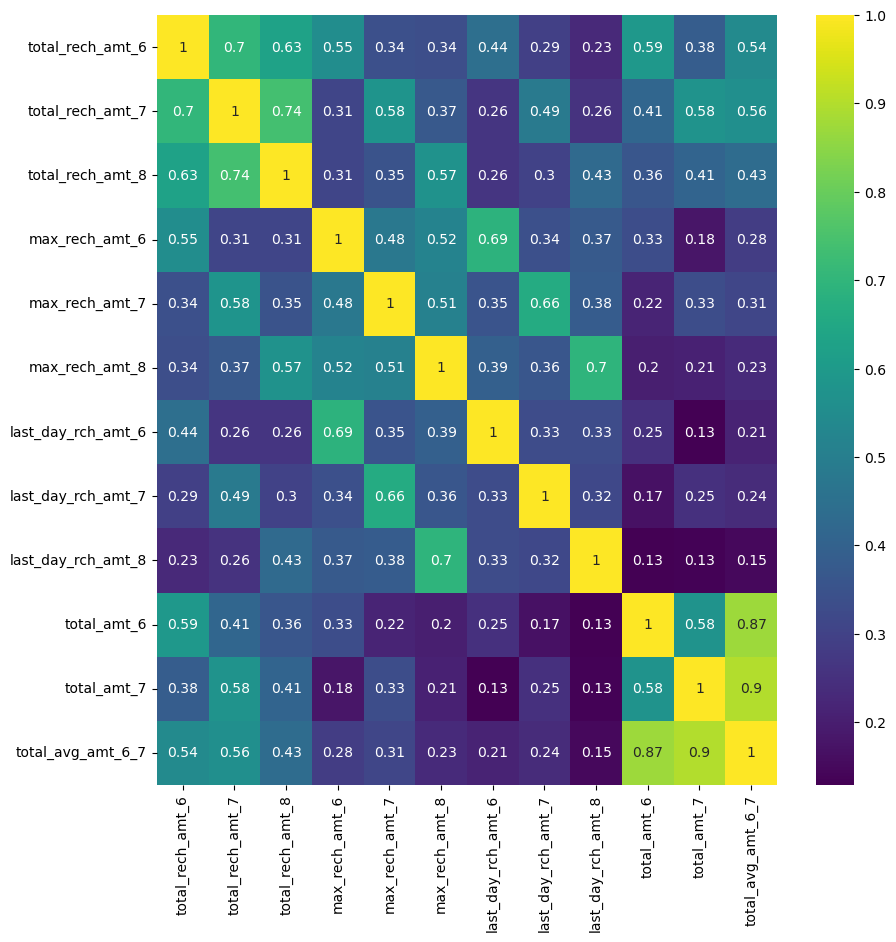

In [83]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

***Observations:***
- A substantial correlation of 74% exists between the total recharge amount in month 7 and month 8.
- Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
- This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

<Figure size 1400x800 with 0 Axes>

<Axes: >

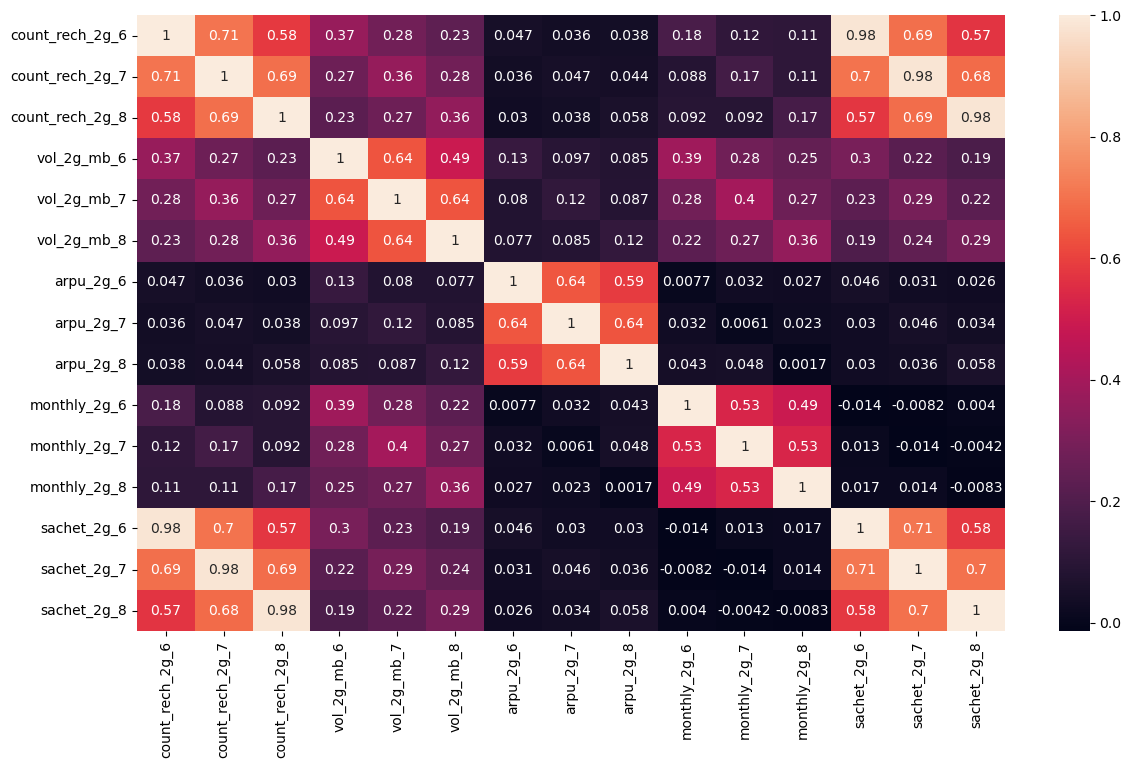

In [84]:
# data2g
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

***Observations:***
- There is a strong correlation between recharge quantities in months 7 and 8.

<Figure size 1200x700 with 0 Axes>

<Axes: >

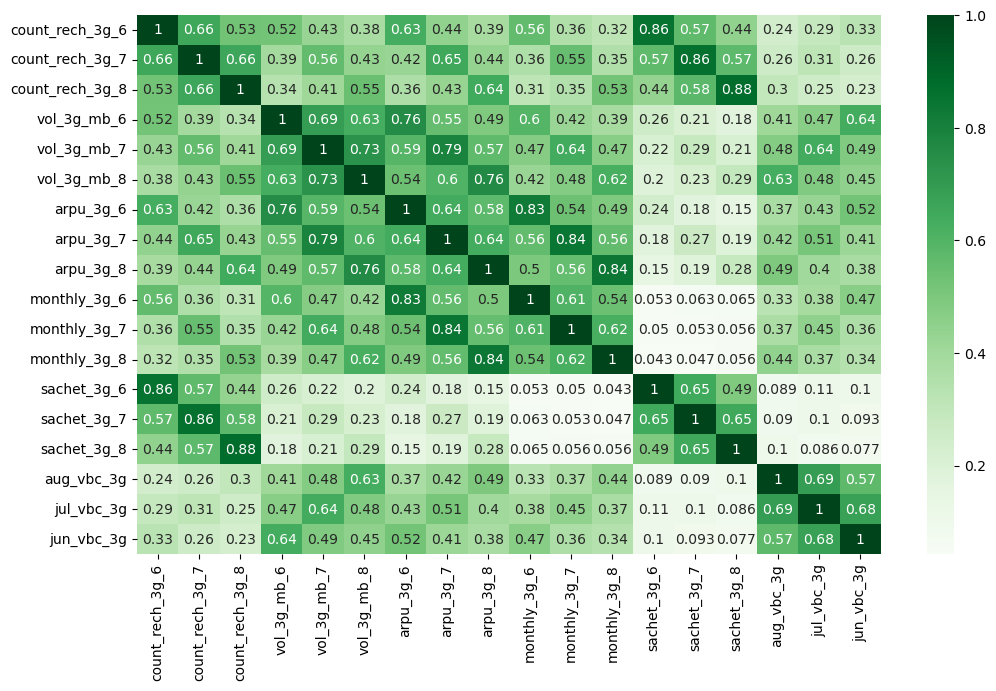

In [85]:
#data3g
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

***Observations:***
- There is a strong correlation between recharge quantities in months 7 and 8.

<Figure size 2500x2500 with 0 Axes>

<Axes: >

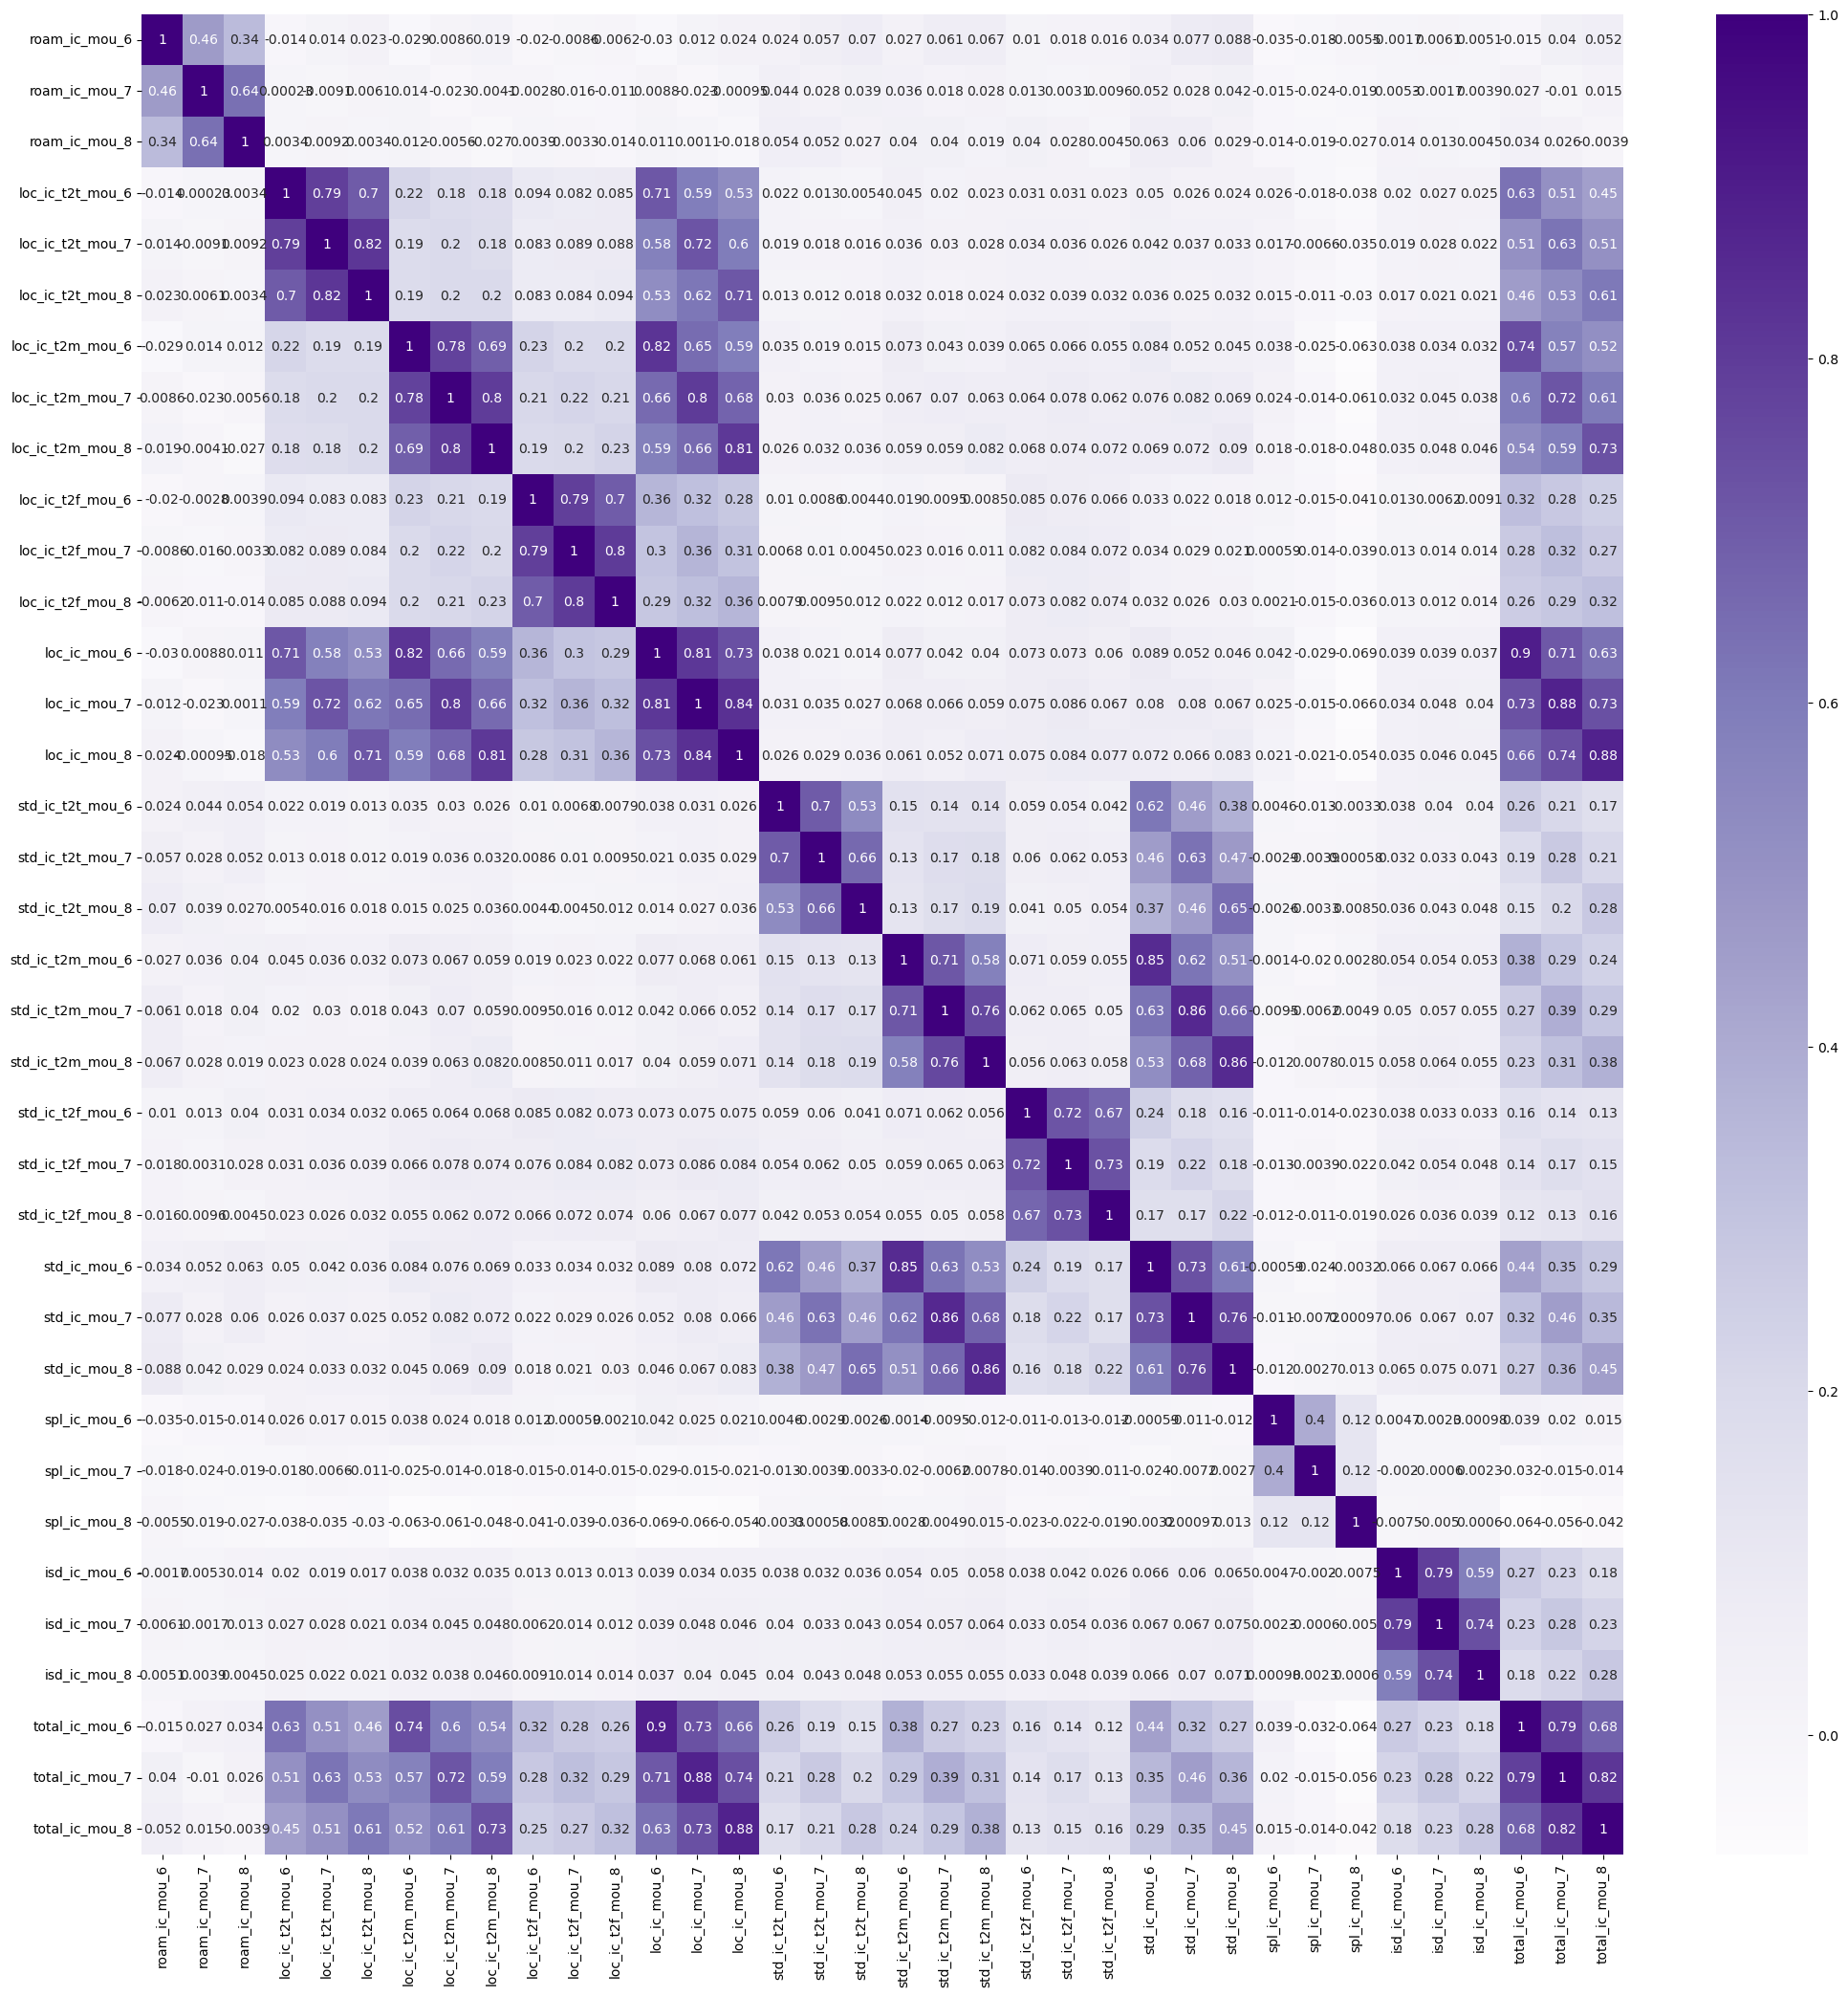

In [86]:
#ic_mou_data
plt.figure(figsize=(25, 25))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

***Observations:*** <br/><br/>
The following variables or features exhibit a remarkably high correlation:

1. total_ic_mou_6 and loc_ic_mou_6
2. total_ic_mou_7 and loc_ic_mou_7
3. total_ic_mou_8 and loc_ic_mou_8
4. std_ic_mou_6 and std_ic_t2f_mou_6
5. std_ic_mou_7 and std_ic_t2f_mou_7
6. std_ic_mou_8 and std_ic_t2f_mou_8

<Figure size 1500x1500 with 0 Axes>

<Axes: >

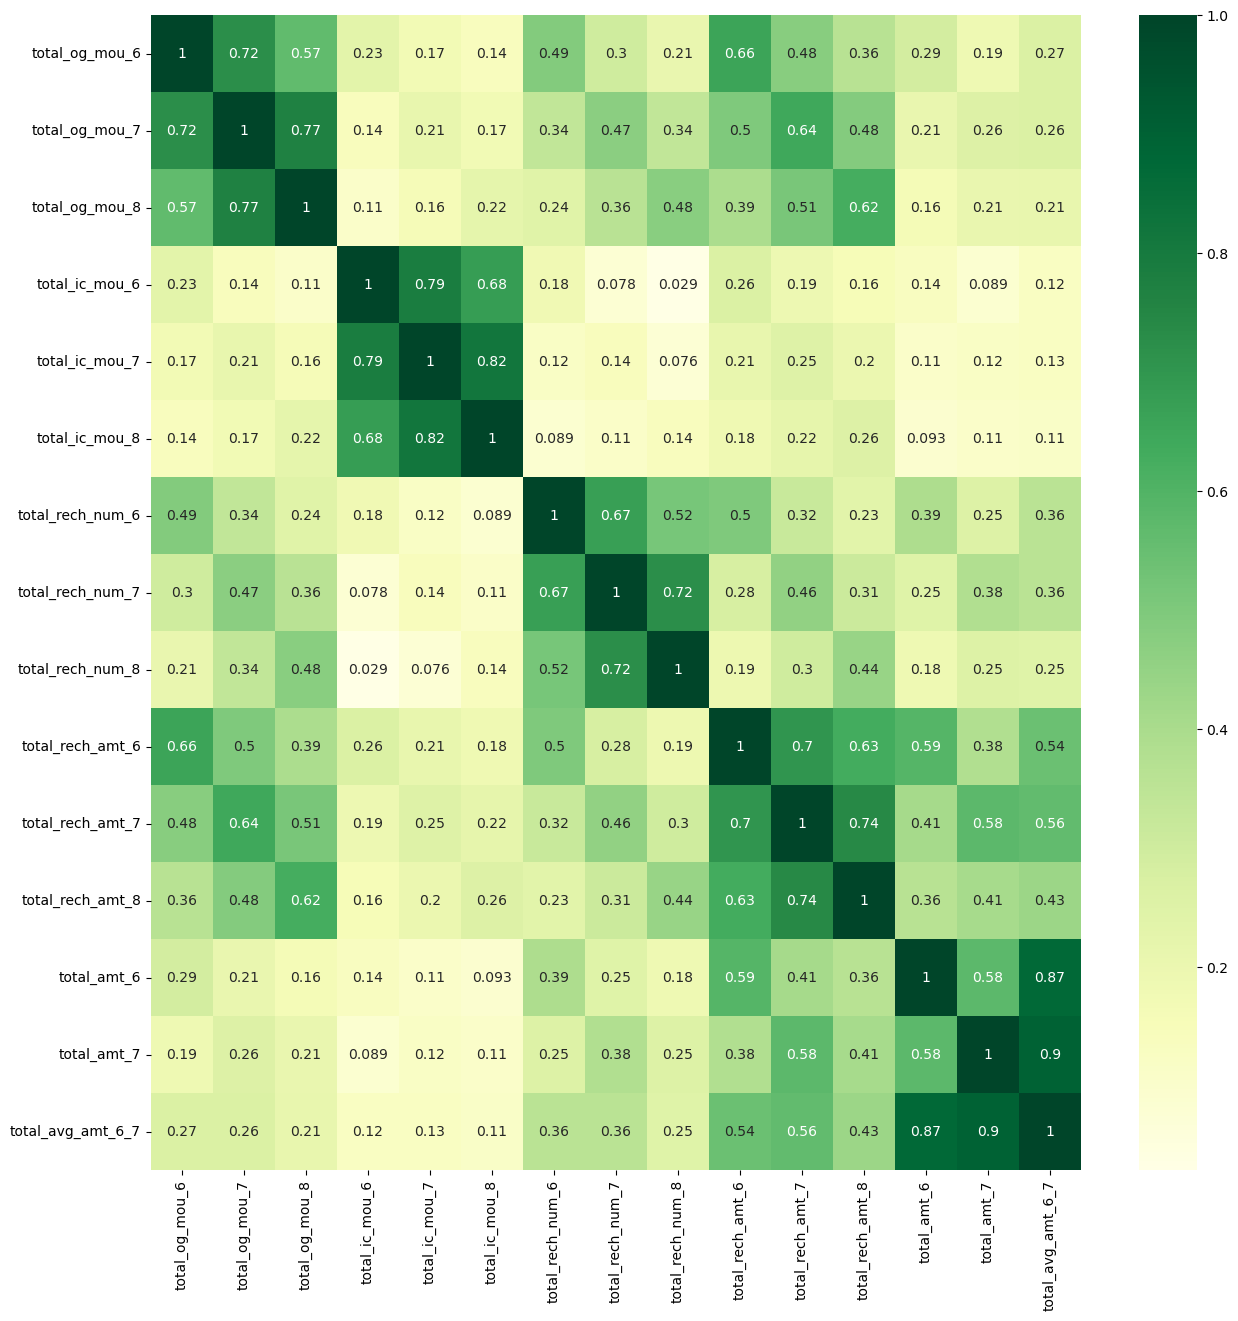

In [87]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='YlGn')
plt.show()

***Observations:***
- There exists a remarkably high correlation between the incoming (82%) and outgoing minutes (77%) of usage in months 7 and 8.
- Heavy usage suggests that customers are less likely to churn.

### Dummy Variable Creation (One Hot Encoding) - Test Set

In [88]:
# Creating dummies for categorical columns
dummy_telecom_test = pd.get_dummies(final_telecom_test[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [89]:
final_telecom_test = pd.concat([final_telecom_test, dummy_telecom_test], axis=1)

In [90]:
# drop the category cols
final_telecom_test.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [91]:
final_telecom_test.info(),final_telecom_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 149 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int32(6), int64(26)
memory usage: 33.4 MB


(None, (30000, 149))

### Outlier Treatment

In [92]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_telecom.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     133.475371    133.281357    132.451803    198.830979    195.892411   
std      296.915791    307.300160    305.943391    313.008970    318.295143   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.880000      6.930000      6.940000     36.090000     32.810000   
50%       35.560000     33.180000     33.640000     99.540000     93.410000   
75%      126.430000    121.870000    122.700000    230.615000    223.275000   
90%      342.264000    342.730000    339.190000    477.000000    475.710000   
95%      610.493000    617.549000    605.862000    727.881000    736.780000   
99%     1431.184200   1467.489600   1452.733880   1524.610400   1524.178000   
max     7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  69999.000000   69999.000000   69999.000000   69999.000000   
mean     195.915944       9.748929       7.031472       6.966478   
std      318.335246      56.502567      55.137890      52.184623   
min        0.000000       0.000000       0.000000       0.000000   
25%       33.280000       0.000000       0.000000       0.000000   
50%       95.110000       0.000000       0.000000       0.000000   
75%      226.765000       0.000000       0.000000       0.000000   
90%      479.062000      12.082000       7.014568       7.004892   
95%      725.322000      40.136000      23.092000      24.060000   
99%     1500.471000     216.035200     151.233600     153.535000   
max    14007.340000    2850.980000    4155.830000    4169.810000   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   69999.000000   69999.000000   69999.000000      69999.000000   
mean       14.279474       9.915293       9.792499         46.083899   
std        72.370145      57.626265      63.182505        148.184915   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.810000   
50%         0.000000       0.000000       0.000000         12.040000   
75%         0.000000       0.000000       0.000000         41.603000   
90%        23.483600      10.993600      10.380000        101.582000   
95%        69.233000      42.930000      42.292000        172.731000   
99%       286.131600     217.680000     209.380600        535.647000   
max      3775.110000    2812.040000    5337.040000       6431.330000   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean          45.423967         44.680281         91.844780         89.472751   
std          152.145179        150.104827        159.341578        151.556800   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.730000          1.810000         10.280000         10.180000   
50%           11.660000         11.844000         41.210000         40.080000   
75%           40.630000         40.430000        106.860000        104.470000   
90%           98.844000         98.410000        228.298000        222.994000   
95%          170.395000        169.145000        349.197000        341.835000   
99%          519.599200        510.543200        734.889200        714.563000   
max         7400.660000      10752.560000       4696.830000       4557.140000   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean          89.508370          3.675783          3.716382          3.590481   
std          149.981174         13.071142         13.328459         12.704901   
min            0.000000          0.000000          0.000000          0.000000   

In [93]:
numerical_cols = list(final_telecom.select_dtypes(exclude='category'))
numerical_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

The outlier_handling method treats outliers and adjusts skewness in the dataset to improve data robustness and analysis accuracy.

In [94]:
def outlier_handling(dataframe):
    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

In [95]:
#Handling outliers in training set final_telecom
final_telecom[numerical_cols] = final_telecom[numerical_cols].apply(outlier_handling)

In [96]:
# Inspecting the numerical columns again in the training set final_telecom
final_telecom.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean       3.443292      3.385511      3.391196      4.367653      4.311609   
std        1.902196      1.924956      1.924673      1.623411      1.650492   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.183802      2.070653      2.071913      3.613347      3.520757   
50%        3.598955      3.531641      3.545009      4.610556      4.547647   
75%        4.847567      4.811127      4.817859      5.445077      5.412873   
90%        5.838500      5.839856      5.829504      6.169611      6.166908   
95%        6.415904      6.427376      6.408301      6.591510      6.603646   
99%        7.266956      7.291990      7.281891      7.330150      7.329866   
max        8.906219      9.006850      9.282992      9.031616      8.860071   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  69999.000000   69999.000000   69999.000000   69999.000000   
mean       4.312295       0.575071       0.426432       0.431533   
std        1.665189       1.282876       1.111346       1.116679   
min        0.000000       0.000000       0.000000       0.000000   
25%        3.534562       0.000000       0.000000       0.000000   
50%        4.565493       0.000000       0.000000       0.000000   
75%        5.428314       0.000000       0.000000       0.000000   
90%        6.173915       2.571237       2.081261       2.080053   
95%        6.587993       3.716884       3.181880       3.221273   
99%        7.314201       5.380060       5.025416       5.040421   
max        9.547408       7.955769       8.332508       8.335866   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   69999.000000   69999.000000   69999.000000      69999.000000   
mean        0.680952       0.508741       0.505203          2.467176   
std         1.457306       1.273392       1.263857          1.697584   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.040277   
50%         0.000000       0.000000       0.000000          2.568022   
75%         0.000000       0.000000       0.000000          3.751925   
90%         3.198003       2.484373       2.431857          4.630662   
95%         4.251818       3.782597       3.767968          5.157508   
99%         5.659941       5.387609       5.348918          6.285341   
max         8.236450       7.942021       8.582614          8.769092   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean           2.443756          2.452763          3.431137          3.416652   
std            1.693245          1.683976          1.743299          1.729301   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.004668          1.033184          2.423031          2.414126   
50%            2.538447          2.552877          3.742657          3.715521   
75%            3.728821          3.724005          4.680834          4.658427   
90%            4.603609          4.599253          5.435022          5.411619   
95%            5.143971          5.136651          5.858496          5.837249   
99%            6.254980          6.237432          6.601080          6.573070   
max            8.909460          9.282992          8.454856          8.424670   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean           3.425784          0.672701          0.675969          0.668178   
std            1.727052          1.040759          1.043254          1.031389   
min            0.000000          0.000000          0.000000          0.000000   

In [97]:
#Handling outliers in test set final_telecom
final_telecom_test[numerical_cols] = final_telecom_test[numerical_cols].apply(outlier_handling)

In [98]:
# Inspecting the numerical columns again in the test set
final_telecom_test.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       3.438976      3.392049      3.406621      4.354605      4.311240   
std        1.900739      1.927876      1.923072      1.623340      1.649296   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.172476      2.080378      2.099244      3.600868      3.523710   
50%        3.628067      3.550479      3.575907      4.603018      4.544571   
75%        4.835051      4.813992      4.838996      5.430858      5.405163   
90%        5.830013      5.837707      5.845346      6.140451      6.159765   
95%        6.391984      6.411429      6.405832      6.556348      6.590300   
99%        7.219748      7.292883      7.294165      7.321545      7.340629   
max        8.845829      8.910857      8.813556      8.848432      9.176590   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  30000.000000   30000.000000   30000.000000   30000.000000   
mean       4.316861       0.568584       0.428343       0.442240   
std        1.655749       1.279646       1.110836       1.136860   
min        0.000000       0.000000       0.000000       0.000000   
25%        3.537766       0.000000       0.000000       0.000000   
50%        4.573163       0.000000       0.000000       0.000000   
75%        5.416989       0.000000       0.000000       0.000000   
90%        6.170493       2.536312       2.081261       2.080053   
95%        6.569648       3.692871       3.156170       3.264996   
99%        7.321117       5.383877       5.038898       5.108264   
max        9.514056       9.527002       9.640306       9.480090   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   30000.000000   30000.000000   30000.000000      30000.000000   
mean        0.666175       0.509947       0.510630          2.470659   
std         1.438612       1.271930       1.273965          1.708359   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.026042   
50%         0.000000       0.000000       0.000000          2.569554   
75%         0.000000       0.000000       0.000000          3.770344   
90%         3.156192       2.476656       2.414126          4.638528   
95%         4.225387       3.806329       3.766722          5.167534   
99%         5.607494       5.369149       5.467732          6.312252   
max         7.680841       7.538953       7.959105          8.679232   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      30000.000000      30000.000000      30000.000000      30000.000000   
mean           2.451958          2.462169          3.432951          3.425454   
std            1.703368          1.693443          1.743387          1.735260   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.993252          1.029619          2.410542          2.400619   
50%            2.550226          2.552332          3.743131          3.738384   
75%            3.740404          3.738384          4.686842          4.658379   
90%            4.625874          4.636834          5.452368          5.422939   
95%            5.174250          5.169290          5.848352          5.845259   
99%            6.311273          6.268363          6.607883          6.617005   
max            8.876853          8.813556          8.461837          8.402397   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      30000.000000      30000.000000      30000.000000      30000.000000   
mean           3.428489          0.672888          0.681125          0.671630   
std            1.731999          1.038780          1.045141          1.034010   
min            0.000000          0.000000          0.000000          0.000000   

## Model Building and Evaluation

Train-Test Split

Given the availability of the test.csv file for testing purposes, this train-test split will exclusively operate on the train.csv dataset. It involves allocating 80% of the data for training and 20% for validation.

In [99]:
# Partitioning the train dataset into the feature variable 'X' and the response variable 'y'.
X = final_telecom.drop(['churn_probability'], axis=1)
y = final_telecom['churn_probability']

In [100]:
X.shape,y.shape

((69999, 148), (69999,))

In [101]:
X.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.903588     4.831349     0.828552      3.503754      4.581697   
1     0.000000     0.000000     0.000000      0.000000      3.295466   
2     0.425268     2.829087     0.000000      4.007151      4.419443   
3     2.111425     2.833801     0.000000      4.245061      4.375505   
4     3.103689     1.763017     1.964311      4.060271      3.666378   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      1.202972       0.000000            0.0            0.0       0.000000   
1      3.462292       0.000000            0.0            0.0       0.000000   
2      0.000000       0.000000            0.0            0.0       0.000000   
3      3.936325       0.000000            0.0            0.0       0.000000   
4      2.363680       4.000766            0.0            0.0       2.817204   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0       0.000000          1.172482          0.000000   
1            0.0       0.000000          0.000000          0.000000   
2            0.0       0.000000          0.425268          2.637628   
3            0.0       0.966984          2.078191          1.597365   
4            0.0       0.000000          2.412336          1.763017   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          0.246860          1.838961          2.835564          1.202972   
1          0.000000          0.000000          0.000000          0.000000   
2          0.000000          3.223266          0.000000          0.000000   
3          0.000000          3.661251          3.826247          3.203965   
4          1.964311          3.630721          3.038792          1.724551   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0           0.00000          0.000000          0.000000          0.000000   
1           0.00000          0.000000          0.000000          0.000000   
2           0.00000          0.000000          0.000000          1.144223   
3           0.00000          0.000000          0.000000          0.000000   
4           2.56418          0.802002          1.793425          0.000000   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0          0.000000          0.000000      2.143589      2.835564   
1          3.135929          3.427190      0.000000      0.000000   
2          0.000000          0.000000      3.244154      2.637628   
3          0.000000          2.200552      3.826683      3.908818   
4          2.384165          0.000000      4.092843      3.293612   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      1.283708          3.857356          4.831349          0.698135   
1      0.000000          0.000000          0.000000          0.000000   
2      0.000000          0.000000          1.371181          0.000000   
3      3.203965          0.231112          2.569554          0.000000   
4      2.818995          0.000000          0.000000          0.000000   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          2.983153          4.401952          0.000000          0.000000   
1          0.000000          0.000000          0.000000          0.000000   
2          3.399195          4.419443          0.000000          0.000000   
3          2.793004          3.293241          1.722767          0.444686   
4          1.677097          0.000000          0.000000          0.000000   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0      4.191017      5.327828   
1               0.0               0.0      0.000000      0.000000   
2               0.0               0.0      3.399195      4.454231   
3               0.0               0.0      2.842581      3.663305   
4               0.0               0.0      1.677097      0.000000   

   std_og_

In [102]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: category
Categories (2, int64): [0, 1]

In [103]:
# Train test split - 80% training data, 20% validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [104]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (55999, 148)
y_train Shape: (55999,)
X_test Shape: (14000, 148)
y_test Shape: (14000,)


### Handling for Data imbalance Using Synthetic Minority Over-sampling Technique (SMOTE)

In [105]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

<Figure size 1000x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Distribution of churn (imbalanced)')

<Axes: title={'center': 'Distribution of churn (imbalanced)'}, xlabel='churn_probability', ylabel='count'>

<Axes: >

Text(0.5, 1.0, 'Distribution of churn (balanced)')

<Axes: title={'center': 'Distribution of churn (balanced)'}, xlabel='churn_probability', ylabel='count'>

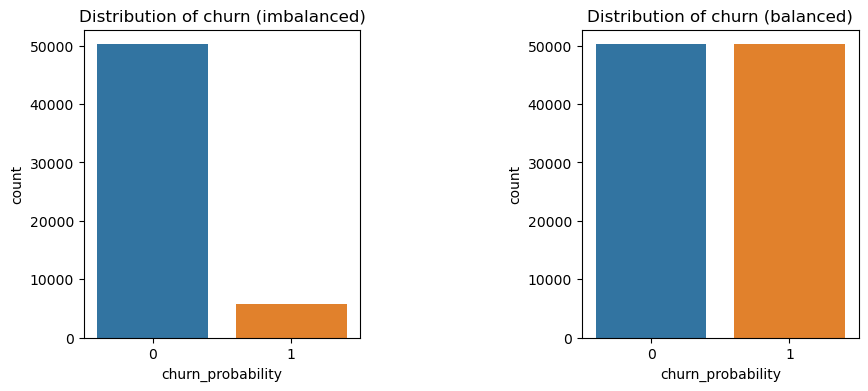

In [106]:
# Checking the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()


### Feature Scaling using SandardScaler - Training Set


In [107]:
# Use StandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

In [108]:
X_train_scaled.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0    -0.006266     0.363567    -1.673584      0.414928      0.416363   
1     1.071539     0.931303     1.034027      0.779597      0.472253   
2    -0.048356     0.158991    -0.512682      0.259480      0.699419   
3     0.221134    -0.376444     0.351033      0.219661     -0.264463   
4    -0.551603    -0.366097    -0.122359      0.356614      0.506844   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0     -2.274150      -0.303444      -0.535765      -0.598439       0.019701   
1      0.495197      -0.546093       1.611073      -0.598439      -0.582223   
2     -0.235196      -0.546093      -0.535765       1.443815      -0.582223   
3      0.801173      -0.546093      -0.535765      -0.598439      -0.582223   
4      0.330435       1.980157      -0.535765      -0.598439       0.489289   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0      -0.570683      -0.631832         -0.693203          1.141678   
1      -0.177716      -0.631832          1.933771          1.717421   
2      -0.570683      -0.631832          0.176956          0.416012   
3      -0.570683      -0.631832          1.041001          0.266149   
4      -0.570683      -0.631832         -0.019146          0.278391   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0         -1.287096          0.214658          1.021079         -1.623215   
1          1.890297          1.366416          0.946077          1.073374   
2         -0.425772          0.070142          0.763179          0.168279   
3          1.106639          0.883143          0.368948          1.365480   
4          0.546941         -0.187515          0.554117          0.422580   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0         -0.613232         -0.611871         -0.622077          0.031194   
1         -0.613232         -0.611871         -0.622077          4.581824   
2          1.257459          0.965715          0.232502         -0.478280   
3         -0.613232         -0.611871         -0.622077         -0.478280   
4         -0.320323         -0.611871         -0.392356         -0.478280   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0         -0.500853         -0.544668      0.020570      0.959057   
1          2.906017          3.403125      1.442254      1.136702   
2         -0.500853         -0.544668      0.108880      0.637036   
3         -0.500853         -0.544668      0.840840      0.291856   
4         -0.500853         -0.544668     -0.175042      0.433528   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0     -1.713643          0.564222         -0.858233         -0.845281   
1      1.263036          0.683066          0.562658          0.101709   
2      0.054204          0.356541          0.491252         -0.016730   
3      1.204887         -0.919396         -0.858233         -0.845281   
4      0.412446         -0.354816         -0.858233         -0.845281   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          0.983571         -1.044487         -1.011956         -0.321513   
1         -1.020286          0.469544         -1.011956         -0.321513   
2          0.859864          1.108192          0.068317         -0.321513   
3         -1.117981         -1.044487         -0.677828         -0.321513   
4          0.987901          0.986327          0.837660         -0.321513   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0         -0.314571          -0.32315      0.710613     -1.170739   
1         -0.314571          -0.32315      0.221241      0.412890   
2         -0.314571          -0.32315      0.582744      0.803234   
3         -0.314571          -0.32315     -1.264484     -1.170739   
4         -0.314571          -0.32315      0.631248      0.634888   

   std_og_

In [109]:
final_telecom_test.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.489819     3.055415     3.182627      4.113493      3.501344   
1     4.337421     3.742657     3.036874      6.164030      6.434290   
2     2.144761     2.181547     2.240710      2.889260      3.846097   
3     1.842136     1.150572     0.000000      3.714547      5.327925   
4     6.113527     6.413508     6.553477      4.126166      3.212455   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      3.578786       0.000000       0.000000       0.000000       0.000000   
1      5.981263       0.000000       0.000000       0.000000       0.000000   
2      3.829511       3.170106       4.648038       3.298795       3.239854   
3      3.219276       0.000000       0.000000       0.000000       0.000000   
4      4.319619       0.000000       0.000000       0.000000       0.000000   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0       0.000000       0.000000          3.253470          3.055415   
1       0.000000       0.000000          4.337421          3.742657   
2       4.001498       4.015301          0.000000          0.000000   
3       0.000000       0.000000          1.842136          0.000000   
4       0.000000       0.000000          0.371564          0.576613   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          3.093766          2.951258          2.475698          2.236445   
1          3.036874          6.162493          6.395395          5.935582   
2          0.000000          0.000000          0.000000          0.000000   
3          0.000000          1.371181          4.601263          3.068518   
4          2.744704          1.220830          1.297463          2.479894   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0          0.000000          2.679651           0.00000               0.0   
1          0.548121          0.000000           0.00000               0.0   
2          0.000000          0.000000           0.00000               0.0   
3          0.000000          0.000000           1.20896               0.0   
4          0.000000          0.000000           0.00000               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0          0.000000          0.029559      3.784417      3.822317   
1          0.000000          0.000000      6.311481      6.461921   
2          0.000000          0.000000      0.000000      0.000000   
3          1.971299          0.000000      2.225704      4.601263   
4          0.000000          0.000000      1.345472      1.490654   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      3.415429          2.066863          0.000000          1.115142   
1      5.986728          0.000000          0.000000          0.000000   
2      0.000000          0.000000          0.000000          0.000000   
3      3.172203          0.000000          1.150572          0.000000   
4      3.277522          6.112531          6.412212          6.532494   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          3.761898          2.161022          3.311637               0.0   
1          0.000000          3.209229          2.927453               0.0   
2          0.000000          0.000000          0.000000               0.0   
3          3.639952          4.557659          0.000000               0.0   
4          4.086648          3.099191          4.161692               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0      3.910622      2.161022   
1               0.0               0.0      0.000000      3.209229   
2               0.0               0.0      0.000000      0.000000   
3               0.0               0.0      3.639952      4.580160   
4               0.0               0.0      6.234470      6.446402   

   std_og_

In [110]:
final_telecom_test.set_index('id', inplace=True)

## Model selection,Building  and evaluation

### Model 1. Logistic Regression with Recursive Feature Elimination (RFE)

In [112]:
#Select top 20 features using RFE
LG = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(LG, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

In [113]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 23),
 ('onnet_mou_7', False, 13),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 75),
 ('offnet_mou_7', False, 37),
 ('offnet_mou_8', False, 38),
 ('roam_ic_mou_6', False, 71),
 ('roam_ic_mou_7', False, 50),
 ('roam_ic_mou_8', False, 51),
 ('roam_og_mou_6', False, 112),
 ('roam_og_mou_7', False, 11),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 43),
 ('loc_og_t2t_mou_7', False, 62),
 ('loc_og_t2t_mou_8', False, 63),
 ('loc_og_t2m_mou_6', False, 21),
 ('loc_og_t2m_mou_7', False, 15),
 ('loc_og_t2m_mou_8', False, 125),
 ('loc_og_t2f_mou_6', False, 106),
 ('loc_og_t2f_mou_7', False, 93),
 ('loc_og_t2f_mou_8', False, 94),
 ('loc_og_t2c_mou_6', False, 58),
 ('loc_og_t2c_mou_7', False, 87),
 ('loc_og_t2c_mou_8', False, 84),
 ('loc_og_mou_6', False, 22),
 ('loc_og_mou_7', False, 14),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 113),
 ('std_og_t2t_mou_7', False, 17),
 ('std_og_t2t_mou_8', True, 1),
 ('std_og_t2m_mou_6', False, 73),
 ('std_

In [114]:
#Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['onnet_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8',
       'std_og_mou_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_mou_7',
       'spl_ic_mou_8', 'total_og_mou_8', 'total_ic_mou_8', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'last_day_rch_amt_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'aon'],
      dtype='object')

In [115]:
X_train_final = X_train_scaled[selected_features]
LG.fit(X_train_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [116]:
y_train_smote_pred = LG.predict(X_train_final)

In [117]:
def calculate_classification_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [118]:
# Calculate metrics on the training set
calculate_classification_metrics(y_train_smote, y_train_smote_pred)

Confusion Matrix

[[44744  5515]
 [ 7897 42362]]


Metric   Value
0             Accuracy  0.8666
1          Sensitivity  0.8429
2          Specificity  0.8903
3            Precision  0.8848
4  False Positive Rate  0.1097
5   True Positive Rate  0.8429

In [119]:
# Retain only the selected feature from the final model
X_test_final = X_test_scaled[selected_features]
X_test_final.head()

onnet_mou_8  roam_og_mou_8  loc_og_mou_8  std_og_t2t_mou_8  \
3425     -1.673584      -0.631832     -1.713643         -0.845281   
33067     0.018043       2.612818     -1.713643         -0.845281   
52420    -1.673584      -0.206915     -1.713643         -0.845281   
5220     -1.673584      -0.631832     -1.713643         -0.845281   
33958    -0.120329       0.728006     -0.760155          0.416684   

       std_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2m_mou_7  loc_ic_mou_7  \
3425      -1.126126          0.404527          0.174772      0.158825   
33067     -1.126126          1.188428          0.178505      0.514125   
52420     -1.126126         -1.451118         -1.931241     -2.084893   
5220      -1.126126         -1.451118         -0.859544     -1.057097   
33958      0.349663         -0.341004         -0.041055     -0.140439   

       spl_ic_mou_8  total_og_mou_8  total_ic_mou_8  total_rech_num_8  \
3425      -0.350205       -0.839386       -0.589355         -0.693099   
33067     -0.350205       -1.196263       -1.237443          0.592516   
52420     -0.350205       -1.196263       -1.237443         -0.693099   
5220      -0.350205       -1.196263       -0.131456         -0.166983   
33958     -0.350205        0.258448        0.120432         -0.316022   

       total_rech_amt_6  total_rech_amt_7  max_rech_amt_6  max_rech_amt_7  \
3425          -0.549439          0.912386       -0.496891        0.270820   
33067          0.993798          0.991007        0.612380        0.720091   
52420          0.463067         -0.169712        0.520547        0.231026   
5220          -0.687000         -0.232749       -0.258901       -0.166225   
33958         -2.376578          0.331611       -2.357312        0.720091   

       last_day_rch_amt_8  vol_3g_mb_8  monthly_2g_8       aon  
3425             -0.88669    -0.332619     -0.219113  0.147477  
33067            -0.88669    -0.332619     -0.219113  0.138173  
52420            -0.88669    -0.332619     -0.219113  0.041307  
5220              1.30440     2.698919     -0.219113  1.904096  
33958            -0.88669    -0.332619     -0.219113  1.264053

In [120]:
# Get the predicted values from the linear model
y_test_pred = LG.predict(X_test_final)

In [121]:
confusion = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(confusion)

[[11256  1352]
 [  241  1151]]


In [122]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_true=y_test, y_pred=y_test_pred)
metrics_df

Confusion Matrix

[[11256  1352]
 [  241  1151]]


Metric   Value
0             Accuracy  0.8862
1          Sensitivity  0.8269
2          Specificity  0.8928
3            Precision  0.4598
4  False Positive Rate  0.1072
5   True Positive Rate  0.8269

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 28.249999999999986, 'Predicted labels')

Text(62.249999999999986, 0.5, 'True labels')

Text(0.5, 1.0, 'Confusion Matrix')

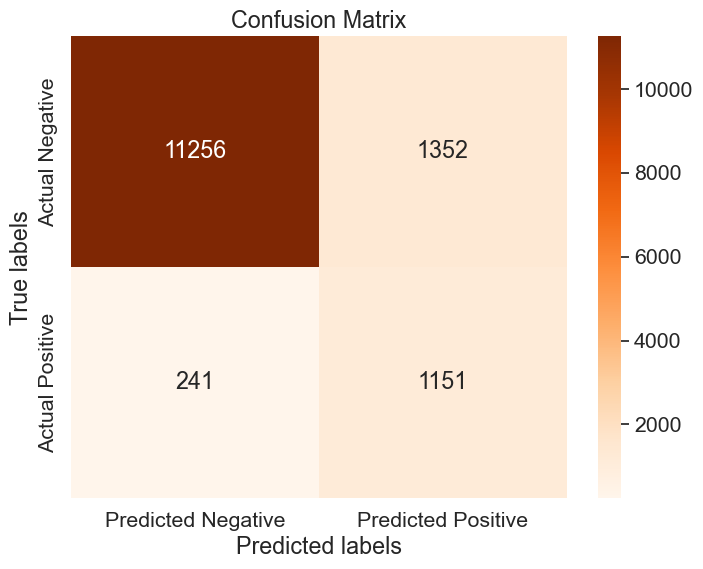

In [123]:
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix into a 2x2 array
cm_array = np.array(confusion).reshape(2,2)

# Create the heatmap
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(cm_array, annot=True, cmap='Oranges', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [124]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

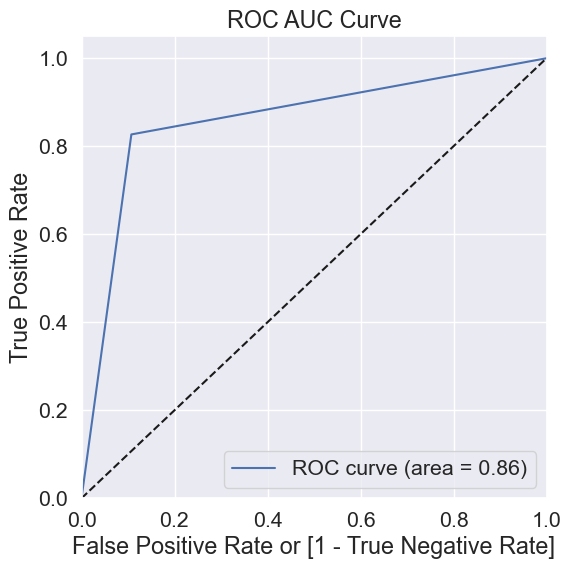

In [125]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_test, y_test_pred)

In [126]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_test, y_test_pred))

'0.86'

### Model 2. Logistic Regression with PCA and Hyperparameter Tuning

In [127]:
pca = PCA()

In [128]:
pca_components = pca.fit_transform(X_train)
pca_components

array([[-1.43427800e+01, -6.58108616e+00, -1.08667761e+00, ...,
         9.98743164e-03,  1.00652492e-02, -8.87281928e-04],
       [ 7.93911262e+00,  3.40748201e-02, -6.68490658e+00, ...,
         3.38641088e-03,  3.31868402e-03, -5.92844053e-04],
       [ 7.31572775e+00,  5.36129122e+00,  7.85965434e+00, ...,
         5.12612302e-03,  3.39639491e-03, -6.61193327e-03],
       ...,
       [-1.18115847e+00,  2.72896801e+00, -7.07297540e+00, ...,
         8.71488843e-06,  3.95498743e-03,  3.50357977e-03],
       [ 4.43532140e+00,  9.37119768e+00,  1.42633708e+01, ...,
        -9.52033139e-02, -1.05021339e-02,  7.26569142e-03],
       [ 1.38641313e+01,  1.00607347e+01, -2.34177153e+00, ...,
        -5.54796003e-02,  3.16991780e-02, -1.71794928e-02]])

<Axes: >

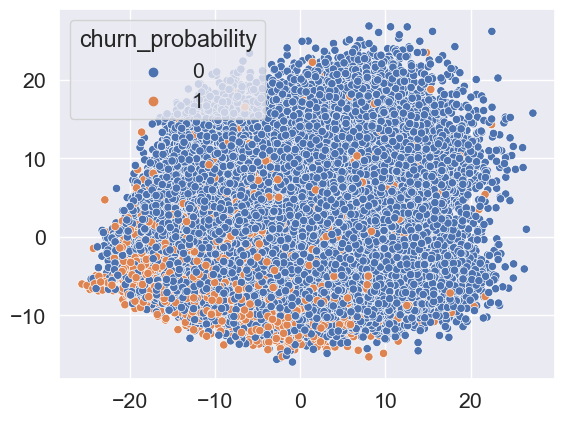

In [129]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

<Axes: >

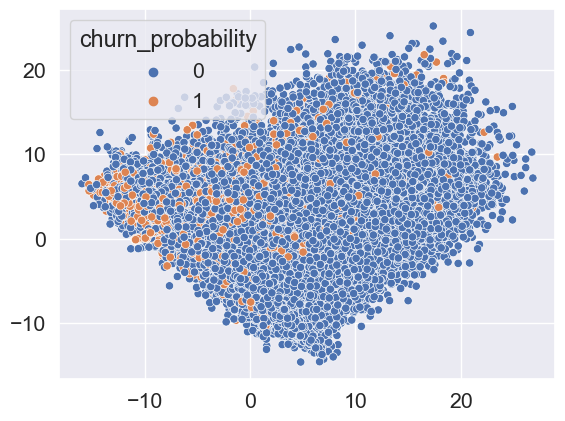

In [130]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

As we can see, there is a clear class imbalance and we have addressed this below using SMOTE


In [131]:
X = high_telecom_train.copy().drop(['churn_probability'], axis=1)
y = high_telecom_train.copy()['churn_probability']
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [133]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=20)
smote = SMOTE(random_state=2)
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [134]:
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    lr
)

In [135]:
# Define hyperparameters grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
}

In [136]:
# Instantiate GridSearchCV
lr_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [137]:
# Fit the model using GridSearchCV
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=20)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           tol=0.001))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [138]:
lr_best_estimator

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('smote', SMOTE(random_state=2)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=20)),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=1000, random_state=42,
                                    solver='liblinear', tol=0.001))])

In [139]:
# Predict values on the training set
y_train_pred = lr_grid_search.predict(X_train)

In [140]:
# Predict values on the test set
y_test_pred = lr_grid_search.predict(X_test)

In [141]:
y_test_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [142]:
# Metrics of the training set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[38409 11850]
 [  995  4745]]


Metric   Value
0             Accuracy  0.7706
1          Sensitivity  0.8267
2          Specificity  0.7642
3            Precision  0.2859
4  False Positive Rate  0.2358
5   True Positive Rate  0.8267

In [143]:
# Metrics of the testn set
calculate_classification_metrics(y_test, y_test_pred)

Confusion Matrix

[[9789 2819]
 [ 233 1159]]


Metric   Value
0             Accuracy  0.7820
1          Sensitivity  0.8326
2          Specificity  0.7764
3            Precision  0.2914
4  False Positive Rate  0.2236
5   True Positive Rate  0.8326

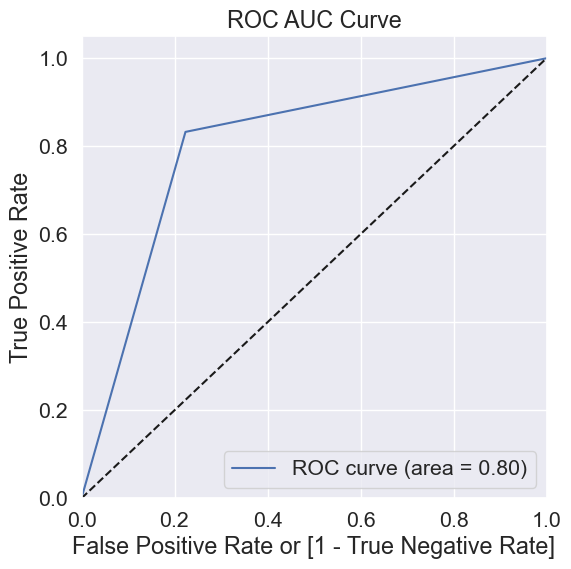

In [144]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_test, y_test_pred)

### Model 3. Decision Tree with PCA and GridSearchCV

In [145]:
dt = DecisionTreeClassifier(random_state=42)

In [146]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [147]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    dt
)

In [148]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [149]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [150]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [151]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on train set using the best model
y_train_pred = grid_search.predict(X_train)

# Predict on validation set using the best model
y_val_pred = grid_search.predict(X_test)

In [152]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[42983  7276]
 [  990  4750]]


Metric   Value
0             Accuracy  0.8524
1          Sensitivity  0.8275
2          Specificity  0.8552
3            Precision  0.3950
4  False Positive Rate  0.1448
5   True Positive Rate  0.8275

In [153]:
# Metrics on the validation set
calculate_classification_metrics(y_test, y_val_pred)

Confusion Matrix

[[10618  1990]
 [  307  1085]]


Metric   Value
0             Accuracy  0.8359
1          Sensitivity  0.7795
2          Specificity  0.8422
3            Precision  0.3528
4  False Positive Rate  0.1578
5   True Positive Rate  0.7795

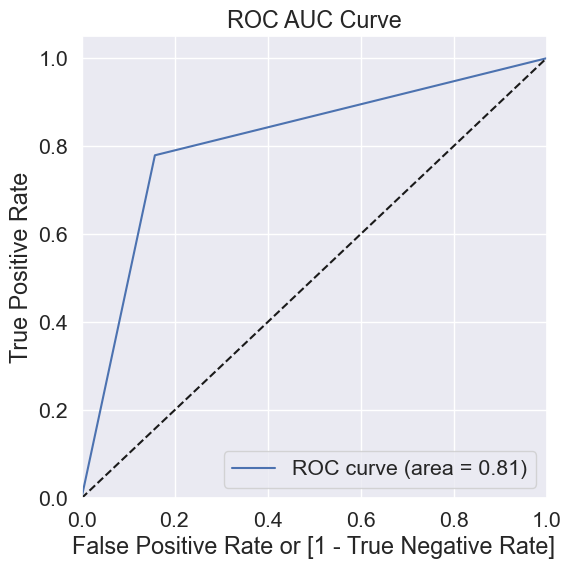

In [154]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_test, y_val_pred)

### Model 4. Random Forest Classifier with PCA and Hyperparameter Tuning

In [155]:
RF = RandomForestClassifier(random_state=42)

In [156]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
  RF
)

In [157]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': [100],  
    'randomforestclassifier__max_depth': [5, 10],       
    'randomforestclassifier__min_samples_split': [2, 5, 10],}

In [158]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [159]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [160]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_test)

Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 100}


In [161]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[44507  5752]
 [  831  4909]]


Metric   Value
0             Accuracy  0.8824
1          Sensitivity  0.8552
2          Specificity  0.8856
3            Precision  0.4605
4  False Positive Rate  0.1144
5   True Positive Rate  0.8552

In [162]:
# Metrics on the test set
calculate_classification_metrics(y_test, y_test_pred)

Confusion Matrix

[[11017  1591]
 [  317  1075]]


Metric   Value
0             Accuracy  0.8637
1          Sensitivity  0.7723
2          Specificity  0.8738
3            Precision  0.4032
4  False Positive Rate  0.1262
5   True Positive Rate  0.7723

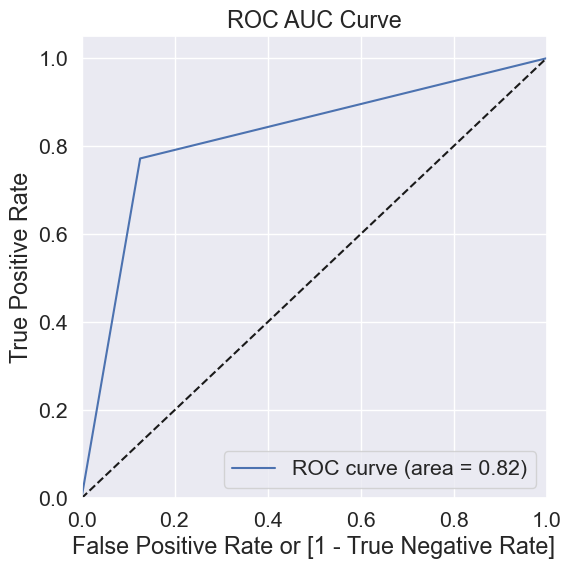

In [163]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_test, y_test_pred)

### Model 5. AdaBoost Classifier

In [164]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=42)
)

In [165]:
# Build the model
adaboost_model = pipe.fit(X_train, y_train)

In [166]:
# Predict on train set using the best model
y_train_pred = adaboost_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = adaboost_model.predict(X_test)

In [167]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[42366  7893]
 [ 1151  4589]]


Metric   Value
0             Accuracy  0.8385
1          Sensitivity  0.7995
2          Specificity  0.8430
3            Precision  0.3676
4  False Positive Rate  0.1570
5   True Positive Rate  0.7995

In [168]:
# Metrics on the validation set
calculate_classification_metrics(y_test, y_test_pred)

Confusion Matrix

[[10629  1979]
 [  288  1104]]


Metric   Value
0             Accuracy  0.8381
1          Sensitivity  0.7931
2          Specificity  0.8430
3            Precision  0.3581
4  False Positive Rate  0.1570
5   True Positive Rate  0.7931

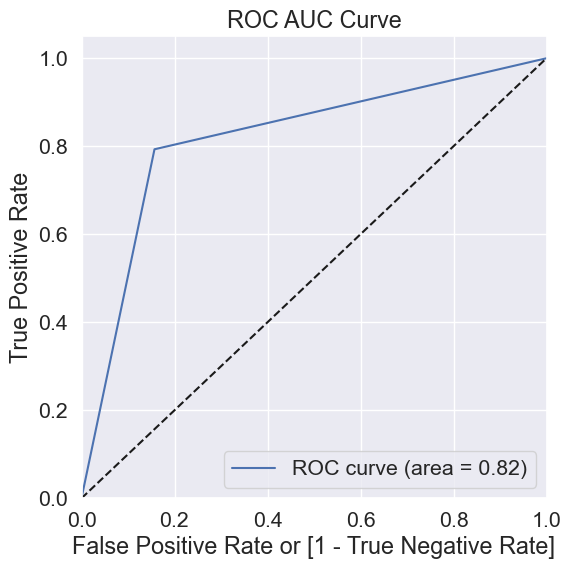

In [169]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_test, y_test_pred)

### Model 6. XGBoost Classifier

In [170]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    XGBClassifier(random_state=42)
)

In [179]:
# Define hyperparameters for grid search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],  
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

In [180]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [181]:
%%time
# Train the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_test)

In [ ]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

In [ ]:
# Metrics on the validation set
calculate_classification_metrics(y_test, y_test_pred)

In [ ]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_test, y_test_pred)

### Create `submission.csv` file for final submission on Kaggle

For our Kaggle submission, we've opted for logistic regression with Recursive Feature Elimination (RFE) due to the platform's evaluation metric being accuracy. This model consistently achieves approximately 85% accuracy on both the training and test sets. Notably, it also demonstrates a commendable accuracy of 93.8% on previously unseen data.

In [171]:
final_telecom_test

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
69999     3.489819     3.055415     3.182627      4.113493      3.501344   
70000     4.337421     3.742657     3.036874      6.164030      6.434290   
70001     2.144761     2.181547     2.240710      2.889260      3.846097   
70002     1.842136     1.150572     0.000000      3.714547      5.327925   
70003     6.113527     6.413508     6.553477      4.126166      3.212455   
...            ...          ...          ...           ...           ...   
99994     5.785240     5.525493     5.657424      5.254156      5.118832   
99995     5.578937     6.148981     6.478909      4.696198      4.829193   
99996     2.491551     2.765690     3.041661      3.643882      2.875822   
99997     4.818183     3.936325     3.312730      7.525688      6.993777   
99998     3.370394     3.524300     4.209309      4.689327      5.491125   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
69999      3.578786       0.000000       0.000000       0.000000   
70000      5.981263       0.000000       0.000000       0.000000   
70001      3.829511       3.170106       4.648038       3.298795   
70002      3.219276       0.000000       0.000000       0.000000   
70003      4.319619       0.000000       0.000000       0.000000   
...             ...            ...            ...            ...   
99994      5.406992       4.485936       2.758743       0.000000   
99995      5.251016       1.481605       0.000000       0.000000   
99996      3.834710       0.000000       0.000000       3.242202   
99997      5.727369       0.000000       3.120601       0.000000   
99998      5.807061       4.909267       4.231058       4.961305   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
69999       0.000000       0.000000       0.000000          3.253470   
70000       0.000000       0.000000       0.000000          4.337421   
70001       3.239854       4.001498       4.015301          0.000000   
70002       0.000000       0.000000       0.000000          1.842136   
70003       0.000000       0.000000       0.000000          0.371564   
...              ...            ...            ...               ...   
99994       4.731186       2.247072       0.000000          5.375232   
99995       2.228939       0.000000       0.000000          1.805005   
99996       0.000000       0.000000       2.808197          2.491551   
99997       0.000000       3.330059       0.000000          0.722706   
99998       4.873899       4.415703       5.197613          0.000000   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
69999          3.055415          3.093766          2.951258          2.475698   
70000          3.742657          3.036874          6.162493          6.395395   
70001          0.000000          0.000000          0.000000          0.000000   
70002          0.000000          0.000000          1.371181          4.601263   
70003          0.576613          2.744704          1.220830          1.297463   
...                 ...               ...               ...               ...   
99994          5.459415          5.628484          5.092277          5.070098   
99995          2.908539          2.650421          3.154444          3.544720   
99996          2.036012          2.149434          3.175133          2.223542   
99997          1.759581          0.000000          4.080246          4.402809   
99998          1.806648          2.912894          0.000000          2.571849   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                           

In [172]:
submission_data = final_telecom_test[selected_features]
submission_data.shape

(30000, 20)

In [173]:
final_telecom_test['churn_probability'] = LG.predict(submission_data)
output = final_telecom_test[['churn_probability']]
output.head()

churn_probability
id                      
69999                  0
70000                  0
70001                  1
70002                  0
70003                  0

In [176]:
#final_telecom_test['churn_probability'] = lr_grid_search.predict(final_telecom_test)
#output = final_telecom_test[['churn_probability']]
#output.head()

In [174]:
output.to_csv('submission.csv',index=True)

### LR with PCA subission file

### Business Recommendations

Based on the analysis of our logistic regression model with RFE, here are some business ideas to improve churn rate:

1. **Roaming Offers**: Provide personalized roaming packages to frequent roamers.
2. **Local Call Promotions**: Offer competitive rates and bonuses for local calls.
3. **Data Recharge Strategies**: Promote data packs with targeted marketing campaigns.
4. **High-Value Recharge Incentives**: Offer discounts for high-value recharges to retain customers.
5. **Service Engagement Initiatives**: Enhance engagement through loyalty programs and personalized offers.
6. **Retention Campaigns**: Target customers with low recharge activity with special offers.
7. **Non-Data User Promotions**: Encourage non-data users to try data services with bundle offers.
8. **Night Pack Revival**: Revive night pack usage through attractive offers and incentives.

Implementing these strategies can effectively reduce churn and improve customer retention in your telecom business.

### Summary

After evaluating various models, including Logistic Regression with Recursive Feature Elimination (RFE), Logistic Regression with hyperparameter tuning, and PCA, as well as Decision Tree, Random Forest, Adaboost, and XGBoost classifiers with hyperparameter tuning and PCA, it's evident that only Logistic Regression with PCA consistently demonstrates the highest sensitivity in both the train and validation sets. Consequently, this model should be considered as the final choice. Other models, although showing promising accuracy in the training phase, perform poorly on the test set, suggesting overfitting.

In the context of telecom churn, where minimizing churn rate is crucial, sensitivity emerges as the most pertinent metric. Hence, based on this criterion, the Logistic Regression model with PCA stands out as the most suitable choice among all alternatives.

### Important features - Logistic Regression with PCA

In [177]:
feature_coefficients = lr_best_estimator.named_steps['logisticregression'].coef_
feature_coefficients

array([[-0.32831148,  0.06429442,  0.40139529, -0.0988058 , -0.01784986,
        -0.68268568,  0.08953935,  0.03064498,  0.05567189,  0.10606526,
        -0.12555839,  0.09812447,  0.07550153, -0.03021185,  0.08574525,
         0.10296173, -0.00148266,  0.39033108,  0.1085068 , -0.05923613]])

#### Observation

We can see most of the top variables have negative coefficients. That means, the variables are inversely correlated with the churn probablity.

In [178]:
for i, component in enumerate(feature_coefficients[0]):
    print(f"PC{i+1}: {component}")

PC1: -0.3283114798999892
PC2: 0.06429442240617943
PC3: 0.4013952890217023
PC4: -0.09880579899896735
PC5: -0.017849864067346014
PC6: -0.6826856832770908
PC7: 0.0895393470808188
PC8: 0.030644984121357743
PC9: 0.05567188613219502
PC10: 0.10606525605526793
PC11: -0.12555839050970843
PC12: 0.0981244721210192
PC13: 0.07550152510981523
PC14: -0.03021184800046694
PC15: 0.08574524966332531
PC16: 0.10296172789604308
PC17: -0.0014826628201576367
PC18: 0.3903310768732232
PC19: 0.10850679955793763
PC20: -0.059236132491303814
